# Text Mining
In diesem Notebook werden die von der Gruppe 1 bereitstellten Dokumenten aufbereitet und ein Text Mining Verfahren wird ausgeführt, sodass die Informationen dieser Dokumente in der Form einer Knowledge-Graph-Datenbank zur Gruppe 3 bereitgestellt wird.

## Import der Bibliotheken

#### Basis-Bibliotheken für Datenbearbeitung

In [1]:
import numpy as np
import pandas as pd

#### Bibliotheken für NLP und Textbearbeitung

In [2]:
import re # RegEx (Regular Expressions für Python für Textbearbeitung)
import spacy # Spacy für NLP
from spacy import displacy # Graphisches Werkzeug für die Visualisierung der Dependencies (DEP) und Parts of Speach (POS)
from spacy.matcher import Matcher # Spacy Objekt, um Muster im Text zu finden
from spacy.tokens import Span # Spacy Objekt, um Texte aufzuteilen
import de_core_news_md # Spacy-Wortschatz auf Deutsch 
nlp = de_core_news_md.load() # Erstellung ein Spacy NLP objekt auf basis von dem hochgeladenen Spacy-Wortschatz auf Deutsch 

#### Unterstützungsbibliotheken

In [3]:
import wikipediaapi # api für die Verbindung mit der Wikipedia-Website
import concurrent.futures # Unterstützungsbibliothek für die Erstellung eines Wikipedia-Scrapers
from tqdm import tqdm # Unterstützungsbibliothek für die Erstellung eines Wikipedia-Scrapers

#### Visualisierungswerkzeuge

In [4]:
import matplotlib.pyplot as plt # Basis-Visualisierungstool für Python
import networkx as nx # Visualisirungsbibliothek für Beziehungsdarstellung

#### Elastic Search api

In [5]:
from elasticsearch import Elasticsearch, helpers # Import von Elastic Search Objekten für Python
import sys, json, os # Unterstützte Datentypen

## Daten Hochladen - Elastic Search

In [6]:
'''
Importieren der von Gruppe 1 im Elastic Search bereitgestellten Dokumente.
'''

es = Elasticsearch(["http://vala.win.hs-heilbronn.de"], http_auth=("MID", "MID202002"), timeout=600, port=9200)
response = es.search(index="mid_beispieldaten_v9", body= {}, size=8000)
print('Größe der importierten Daten:', len(response['hits']['hits']))

Größe der importierten Daten: 7617


In [7]:
response['hits']['hits'][:5] # Ansicht der ersten 5 Dokumenten zwckecks Plausibilisierung des Imports

[{'_id': 'uoEBxXIB7QWdo8C6vTMN',
  '_index': 'mid_beispieldaten_v9',
  '_score': 1.0,
  '_source': {'Author': None,
   'Course': '',
   'Course_abbreviation': '',
   'Course_location': '',
   'Creation-Date': '2019-11-19T12:17:15',
   'Last-Modified': '2019-11-19T12:17:15',
   'Link': 'www.hs-heilbronn.de/_b/0000000000000024097716bb5dd69a89/4b25a09e1fc943a0b35d33544f9f17b03b696f1a_2578682clip_center_800_600_750b90',
   'Text': None,
   'Title': None,
   'Upload-Date': '2020-06-18T00:42:28.923728Z'},
  '_type': '_doc'},
 {'_id': 'u4EBxXIB7QWdo8C6vTMN',
  '_index': 'mid_beispieldaten_v9',
  '_score': 1.0,
  '_source': {'Author': None,
   'Course': '',
   'Course_abbreviation': '',
   'Course_location': '',
   'Creation-Date': None,
   'Last-Modified': None,
   'Link': 'www.hs-heilbronn.de/21278004/rueckblick-2018-ausblick-2019',
   'Text': ' MR-Aktivitäten - Hochschule Heilbronn Skip to navigation Press Enter. Skip to main content Press Enter. home home Login DE EN Suchen Zielgruppen Die

## Generierung von einem Datensatz mit allen Infomationen
#### **1** - Alle einzigartigen Features herausfinden

In [8]:
'''
Auf Basis von den bereitgestellten und hochgeladenen Dokumenten werden alle einzigartige Features 
(inkl. Daten und Metadaten) erkannt und gespeichert. Diese werden nachher bei der Erstellung eines Pandas-Dataframes verwendet.
'''

features_alone = []
all_features_list = [list(d['_source'].keys()) for d in response['hits']['hits']]
for features in all_features_list:
    for feature in features:
        features_alone.append(feature)
unique_features = set(features_alone)
print(unique_features)

{'Title', 'Creation-Date', 'Text', 'Link', 'Course_location', 'Author', 'Upload-Date', 'Course', 'Course_abbreviation', 'Last-Modified'}


#### **2** - Alle Nötige Infomation aus Elastic Search in einem Dataframe speichern - Hauptdatensatz

In [9]:
'''
Das Dataframe "df" ist das Hauptinput-Dataframe. In diesem Dataframe werden alle Informationen gespeichert, 
die noch zu bearbeiten sind.
'''
df = pd.DataFrame()
error = []
# Alle Informationen, die bearbeitet werden befinden sich unter den Keys ['hits']['hits']
for doc in response['hits']['hits']:
    # Try and Except als fehlertoleranter Ansatz
    try:
        # Extrahieren der Metadaten aus der ersten Ebene des Jason-Elements
        d = {}
        d['ID'] = doc['_id']
        d['index'] = doc['_index']
        d['score'] = doc['_score']

        # Extahieren der Metadaten aus der zweiten Ebene  des Jason-Elements unter dem Key: "_source"
        for feature in unique_features:
            d[feature] = doc['_source'][feature]
        df = pd.concat([df, pd.DataFrame(d, index=[len(df)])])
    # Die Dokumente, die nicht ins Dataframes gespeichert werden könnten, werden in einer Liste gespeichert und 
    # können bezüglich der Vollständigkeit des Dokuments über das Key "_id" nachgeprüft werden
    except:
        error.append(doc['_id'])
# Die fehlerhaften Dokumenten werden dargestellt
print(error, '\n\nFehleranzahl: ', len(error), '\nFehlerquote: ', len(error)/len(df)*100, "%")

['Y4HqxHIB7QWdo8C6sjBU', 'aoHqxHIB7QWdo8C6sjBU', 'WoGYxHIB7QWdo8C6DCP5', 'woGhxHIB7QWdo8C6PCSS', 'u4EGxXIB7QWdo8C6XDQt', 'moEYxXIB7QWdo8C6vDfA', '-4HvxHIB7QWdo8C6WTBi', '3oFUxXIB7QWdo8C6ZEBN'] 

Fehleranzahl:  8 
Fehlerquote:  0.10513865159679327 %


In [10]:
'''
Visualisierung des Dataframes zwecks Plausibilisierung.
'''
df.head()

,Author,Course,Course_abbreviation,Course_location,Creation-Date,ID,Last-Modified,Link,Text,Title,Upload-Date,index,score
0,None,,,,2019-11-19T12:17:15,uoEBxXIB7QWdo8C6vTMN,2019-11-19T12:17:15,www.hs-heilbronn.de/_b/0000000000000024097716b...,None,None,2020-06-18T00:42:28.923728Z,mid_beispieldaten_v9,1.0
1,None,,,,None,u4EBxXIB7QWdo8C6vTMN,None,www.hs-heilbronn.de/21278004/rueckblick-2018-a...,MR-Aktivitäten - Hochschule Heilbronn Skip to...,MR-Aktivitäten - Hochschule Heilbronn,2020-06-18T00:42:06.083993Z,mid_beispieldaten_v9,1.0
2,None,,,,None,vIEBxXIB7QWdo8C6vTMN,None,www.hs-heilbronn.de/1074136/partner-universities,Partner Universities - Hochschule Heilbronn S...,Partner Universities - Hochschule Heilbronn,2020-06-18T00:42:39.586380Z,mid_beispieldaten_v9,1.0
3,None,,,,2016-11-24T20:44:41,vYEBxXIB7QWdo8C6vTMN,2016-11-24T20:44:41,www.hs-heilbronn.de/12598639/IMG_8515_JPG.jpg,None,None,2020-06-18T00:40:12.871729Z,mid_beispieldaten_v9,1.0
4,None,,,,2014-03-21T14:21:15Z,voEBxXIB7QWdo8C6vTMN,2014-05-09T13:02:14Z,www.hs-heilbronn.de/6352921/Criteria-for-Coast...,Abstract This study quantifies fuel savings a...,None,2020-06-18T00:41:59.349752Z,mid_beispieldaten_v9,1.0


In [11]:
'''
Beispieldarstellung eines Texts, der vom NLP-Verfahren bearbeitet wird.
'''
text = df['Text'][1]
text

' MR-Aktivitäten - Hochschule Heilbronn Skip to navigation Press Enter. Skip to main content Press Enter. home home Login DE EN Suchen Zielgruppen Die Hochschule Forschung Internationales Kooperation Login DE EN Studieninteressierte Studierende Mitarbeitende Lehrende Schulen Alumni Unternehmen Presse Hochschule Heilbronn Standorte Fakultäten Studiengänge für Interessierte Studiengänge für Studierende Heilbronn University Graduate School HUGS Semesterterminplan Grundordnung und Satzungen Öffentliche Bekanntmachungen Gremien und Beauftragte Rektorat Hochschulrat Senat Fakultätsräte Hochschulbeauftragte Personalrat Verfasste Studierendenschaft Zentrale Einrichtungen Bibliothek LIV Career Service Institut für mathematisch-naturwissenschaftliche Grundlagen IfG Rechenzentrum Schulkoordination Stipendienstelle Zentrale Studienberatung Zentrum für Studium und Lehre ZfSL Weiterbildung Berufsbegleitende Studiengänge Heilbronner Institut für Lebenslanges Lernen HILL HHN und Gesellschaft Familieng

## NLP-Verfahren
### Erforschung von Spacy - Entwicklung

In [12]:
'''
Visualisierung der NLP-Objekte (Dependencies und Parts-of-Speach) auf Basis von Spacy.
'''
txt = "das interessante Buch wird nicht von Victor heute am schönen Strand gelesen, sondern fährt er das schnelle Auto"
# text = 'Der Text hätte von dem Mann geschrieben werden können' # zu bearbeitetem Text
doc = nlp(txt) # aus einem String hin zu einem Spacy Doc (Textformat mit den analysierten NLP-Objekte)
displacy.render(doc,style='dep', jupyter=True,) # Darstellung des Satzes
for token in doc: # Informationen aus jedem Token
    print(token.text, token.dep_, token.pos_, token.head, [child for child in token.children], [ante for ante in token.ancestors])

das nk DET Buch [] [Buch, wird]
interessante nk ADJ Buch [] [Buch, wird]
Buch sb NOUN wird [das, interessante] [wird]
wird ROOT AUX wird [Buch, gelesen, ,, sondern] []
nicht ng PART Victor [] [Victor, von, gelesen, wird]
von sbp ADP gelesen [Victor] [gelesen, wird]
Victor nk NOUN von [nicht] [von, gelesen, wird]
heute mo ADV gelesen [] [gelesen, wird]
am mo ADP gelesen [Strand] [gelesen, wird]
schönen nk ADJ Strand [] [Strand, am, gelesen, wird]
Strand nk NOUN am [schönen] [am, gelesen, wird]
gelesen oc VERB wird [von, heute, am] [wird]
, punct PUNCT wird [] [wird]
sondern cd CONJ wird [fährt] [wird]
fährt cj VERB sondern [er, Auto] [sondern, wird]
er sb PRON fährt [] [fährt, sondern, wird]
das nk DET Auto [] [Auto, fährt, sondern, wird]
schnelle nk ADJ Auto [] [Auto, fährt, sondern, wird]
Auto oa NOUN fährt [das, schnelle] [fährt, sondern, wird]


In [13]:
'''
Spacy-Methode, um die Spacy-Bezwichnungen bspw. von "Dependencies"(DEP) und "Parts-of-Speach"(POS) erklären zu lassen.
'''
name = 'cj'
print(name, "is equal:",spacy.explain(name))

cj is equal: conjunct


## Erstellung einer NLP-Klasse mit den Objekten und Methoden
Dieser Punkt ist der Kernpunkt des ganzen Projektes. Hier wird das Text Mining und NLP durchgeführt. Diese Klasse ist auf der Open Source Python-Bibliothek Spacy aufgebaut und besteht aus vielfältige Methoden, um die NLP an die deutsche Sprache anzupassen und die Informationen am besten zu extrahieren.

In [1]:
class VictoryNLP():
    
    def __init__(self, name, nlp):
        '''
        Initialisierungsfunktion:
        Das Spacy-NLP-Objekt wird importiert um in der Klasse intialisiert.
        Der Name des Objekts wird in der Klasse importiert und gespeichert.
        '''
        self.name = name # Initialisierung vom Objektname
        self.nlp = nlp # Initialisierung des Spacy-NLP-Objekts
    
    def is_question(self,sent):
        '''
        Prüft, ob der analysierte Satz eine Frage ist.
        ____________________________________________________________________________________________________
        ### Inputs ###
        sent --> Satz, der analysiert wird
        ____________________________________________________________________________________________________
        ### Outputs ###
        True/False --> Boolean, ob der Satz eine Frage ist.
        '''
        return '?' in sent.text # Prüft, ob "?" in dem Satz zu finden ist
    
    def is_question_words_without_obj(self,token):
        '''
        Prüft ob der Token ein W-Fragewort ist, bei dem das Objekt oder Subjekt direkt die W-Fragewort ist.
        ____________________________________________________________________________________________________
        ### Inputs ###
        sent --> Satz, der analysiert wird
        ____________________________________________________________________________________________________
        ### Outputs ###
        True/False --> Boolean, ob der Token ein von den W-Fragewörtern ist.
    
        '''
        question_words_without_obj = ['was', 'wo', 'wer', 'wen', 'wem', 'wohin', 'woher'] # W-Fragewörter, , bei denen das Objekt oder Subjekt direkt die W-Fragewort ist
        return token.text.lower() in question_words_without_obj # Return Boolean, ob der Token ein von den W-Fragewörtern ist.
    
    def get_multiple_elements(self,objs):
        '''
        Bei dieser Methode werden vielfältige Objekte oder Subjekte gesucht. Nicht immer sind die Objekte oder Subjekte direkt
        zu erkennen. Manchmal besteht das Objekt oder das Subjekt aus mehrere Wörter, die nicht sofort von Spacy erkennbar sind.
        Aus diesem Grund, liest die Methode den Satzt wieder durch und verknüpft die vielfältigen Objekte und Subjekte.
        Da das Verfahren gleich für Subjekte und Objekte ist, wird in den Komentare nur über Objekte gesprochen.
        ____________________________________________________________________________________________________
        ### Inputs ###
        objs --> Liste mit den erkannten Objekten
        ____________________________________________________________________________________________________
        ### Outputs ###
        objs --> Bearbeitete Liste von den vielfältigen Objekten
    
        '''
        # Typen von Wörtern, die nicht als Objekte erwünscht sind
        unwanted_tokens = (
        'AUX', # auxiliar verb
        'ADJ', # adjective
        'ADV', # adverb
        'VERB', # verb
        'PART',  # particle
        'DET',  # determiner
        'SCONJ',  # subordinating conjunction
        'PUNCT',  # punctuation
        'SYM',  # symbol
        'X',  # other
        )
        
        # Diese Typen werden nachher gefiltert, weil viele Verknüpfungen zwischen Objekten über diese Typen zu erkennen sind,
        # jedoch werden diese Typen am Ende als Objekte nicht erwünscht, daher werden sie gefiltert.
        obj_filter = (
        'CONJ', # conjunction
        'ADP', # adposition
        )
        
        # Schleife über die Objekte
        for obj in objs:
            # Schleife über die Kinder des Objkets
            for child in obj.children:
                # Voraussetzungen:
                # --> Wenn das POS des Kinds nicht in des Tuples "unwanted_tokens" sich befindet
                # --> Und wenn das Kind kein Interpunktionszeichen ist
                # --> Und wenn das Kind noch nicht in der Objektliste ist
                if child.pos_ not in unwanted_tokens and child.is_punct==False and child not in objs:
                    # Fügt das Kind zu der Objektliste ein
                    objs.append(child)

        # Filtert die Subjekte und Objekte auf basis des Tuples "obj_filter" 
        objs = [obj for obj in objs if obj.pos_ not in obj_filter]
        
        # Rückgabe der vielfältigen Objekte
        return objs
    
    def substitute_pronoun(self,token):
        '''
        Für einen guten Lesefluss werden oft Pronomen angewendet. Durch die Anwendung von Pronomen im Text wird 
        verzichtet, mehrmals die Subjekte oder Objekte zu wiederholen, ohne dass Informationen verloren gehen. 
        Die Beziehung zwischen Pronomen und den Wörtern, auf denen die Pronomen sich beziehen, werden nicht von 
        Spacy erkannt und, um diese Informationen nicht zu verlieren und um herauszufinden, woraus das Pronomen 
        sich bezieht, wurde diese Methode geschrieben.              
        ____________________________________________________________________________________________________
        ### Inputs ###
        token --> Wort aus dem Satz, der analysiert wird
        ____________________________________________________________________________________________________
        ### Outputs ###
        Wenn das Wort, auf dem das Pronomen sich bezieht, erkannt wird:
        obj  --> Wenn das Pronomen in einem Relativsatz sich befindet und das Wort, auf dem das Pronomen sich 
                 bezieht, in einem Hauptsatz zu finden ist.
        subj --> Wenn das Pronomen in einem Konjunktivsatz  ist, wird das Subjekt des Hauptsatzes gewählt, um 
                 das Pronomen zu ersetzen
        case --> 1 bedeutet Charakteristiken aus der Aktivform und 2 bedeutet Charakteristiken aus der Passivform
        
        Sonst:
        token --> Rückgabe desselben Wortes
        '''
        case=1
        
        # Wenn die Abhängigkeit der Wurzel des Wortes ein Relativsatz ist und das Wort ein Pronomen ist
        if token.head.dep_ == 'rc' and token.pos_ == 'PRON':
            # Wird versucht die Wurzel der Wurzel zu speichern (zweite Wurzel)
            try:
                obj = token.head.head
                # Wenn es klappt wird das Pronomen von seiner zweiten Wurzel ersetzt
                # Rückgabe von case 1 (Aktivform)
                return obj, case
            except:
                None
                
        # Wenn die Abhängigkeit der Wurzel des Wortes eine Konjunktion ist und das Wort ein Pronomen ist aber davor befindet sich eine Konjunktion  
        elif token.head.head.head.dep_ == 'cd' and token.pos_ == 'PRON':

            # Wird versucht das Subjekt des früheren Satzes gewählt, um das Pronomen zu ersetzen, wenn der Satz in der Aktivform steht
            try:
                # Holt das Subjekt des anderen Satzs
                subj = [subj for subj in token.head.head.head.head.children if subj.dep_=='sb'][0] 
                # Prüft, ob das Hauptsatz in der Passivform steht
                if subj.head.lemma_ == 'werden':
                    # Findet das Hauptverb
                    oc_verb = [oc for oc in subj.head.children if oc.dep_=='oc'][0]
                    case = 2
                    # Sucht nach den Objekten
                    for i in range(3):
                        try:
                            # Sucht nach einem Objekt Akkusativ
                            obj = [obj for obj in oc_verb.children if obj.dep_=='oa'][0]
                            return obj, case
                        except:
                            # Sucht nach einem Subjekt in der Passivform
                            try:
                                obj = [obj for obj in oc_verb.children if obj.dep_=='sbp'][0]
                                obj = [obj for obj in obj.children if obj.dep_=='nk'][0]
                                return obj, case
                            except:
                                # Sucht nach einem Predikat
                                try:
                                    obj = [obj for obj in oc_verb.children if obj.dep_=='pd'][0]
                                    return obj, case
                                except:
                                    # Prüft, ob die Ebene des Hauptverbs noch nicht erreicht wurde
                                    try:
                                        oc_verb = [oc for oc in oc_verb.children if obj.dep_=='oc'][0]
                                    except:
                                        None
                        
                # Wird versucht das Subjekt des früheren Satzes gewählt, um das Pronomen zu ersetzen        
                else:
                    # Rückgabe von case 1 (Aktivform)
                    return subj, case
            except:
                None
        
        # Wenn die Abhängigkeit der Wurzel des Wortes eine Konjunktion ist und das Wort ein Pronomen ist aber davor befindet sich eine Konjunktion  
        elif token.head.head.dep_ == 'cd' and token.pos_ == 'PRON':

            # Wird versucht das Subjekt des früheren Satzes gewählt, um das Pronomen zu ersetzen, wenn der Satz in der Aktivform steht
            try:
                # Holt das Subjekt des anderen Satzs
                subj = [subj for subj in token.head.head.head.children if subj.dep_=='sb'][0] 
                # Prüft, ob das Hauptsatz in der Passivform steht
                if subj.head.lemma_ == 'werden':
                    # Findet das Hauptverb
                    oc_verb = [oc for oc in subj.head.children if oc.dep_=='oc'][0]
                    case = 2
                    # Sucht nach den Objekten
                    for i in range(3):
                        # Sucht nach einem Objekt Akkusativ
                        try:
                            obj = [obj for obj in oc_verb.children if obj.dep_=='oa'][0]
                            return obj, case
                        except:
                            # Sucht nach einem Subjekt in der Passivform
                            try:
                                obj = [obj for obj in oc_verb.children if obj.dep_=='sbp'][0]
                                obj = [obj for obj in obj.children if obj.dep_=='nk'][0]
                                return obj, case
                            except:
                                # Sucht nach einem Predikat
                                try:
                                    obj = [obj for obj in oc_verb.children if obj.dep_=='pd'][0]
                                    return obj, case
                                except:
                                    # Prüft, ob die Ebene des Hauptverbs noch nicht erreicht wurde
                                    try:
                                        oc_verb = [oc for oc in oc_verb.children if obj.dep_=='oc'][0]
                                    except:
                                        None
                        
                # Wird versucht das Subjekt des früheren Satzes gewählt, um das Pronomen zu ersetzen        
                else:
                    # Rückgabe von case 1 (Aktivform)
                    return subj, case
            except:
                None
        
        # Wenn die Abhängigkeit der Wurzel des Wortes eine Konjunktion ist und das Wort ein Pronomen ist
        elif token.head.dep_ == 'cj' and token.pos_ == 'PRON':
            
            # Wird versucht das Subjekt des früheren Satzes gewählt, um das Pronomen zu ersetzen, wenn der Satz in der Aktivform steht
            try:
                # Holt das Subjekt des anderen Satzs
                subj = [subj for subj in token.head.head.children if subj.dep_=='sb'][0] 
                # Prüft, ob das Hauptsatz in der Passivform steht
                if subj.head.lemma_ == 'werden':
                    # Findet das Hauptverb
                    oc_verb = [oc for oc in subj.head.children if oc.dep_=='oc'][0]
                    case = 2
                    # Sucht nach den Objekten
                    for i in range(3):
                        # Sucht nach einem Objekt Akkusativ
                        try:
                            obj = [obj for obj in oc_verb.children if obj.dep_=='oa'][0]
                            return obj, case
                        except:
                            # Sucht nach einem Subjekt in der Passivform
                            try:
                                obj = [obj for obj in oc_verb.children if obj.dep_=='sbp'][0]
                                obj = [obj for obj in obj.children if obj.dep_=='nk'][0]
                                return obj, case
                            except:
                                # Sucht nach einem Predikat
                                try:
                                    obj = [obj for obj in oc_verb.children if obj.dep_=='pd'][0]
                                    return obj, case
                                except:
                                    # Prüft, ob die Ebene des Hauptverbs noch nicht erreicht wurde
                                    try:
                                        oc_verb = [oc for oc in oc_verb.children if obj.dep_=='oc'][0]
                                    except:
                                        None
                # Wird versucht das Subjekt des früheren Satzes gewählt, um das Pronomen zu ersetzen        
                else:
                    # Rückgabe von case 1 (Aktivform)
                    return subj, case
            except:
                None
        else:
            # Wenn die beiden Fälle nicht zugetroffen werden, bleibt das Pronomen
            return token, case
    
    def get_chunks(self,subjs, sent):
        '''
        Die Methode "get_chunks" findet in dem Satz, wo das Subjekt sich befindet, für jedes vorher gefundenen
        Objekt sein entsprechendes sogenanntes "Noun Chunk". Das ist die Kombination von Wörter die, das Objekt 
        oder Subjekt beschreiben. Nehmen wir zum Beispiel der Satz "Peter will heute das schnelle rote Auto 
        fahren.". In diesem Fall ist das Substantiv "Auto" das Objekt und "das schnelle rote Auto" das 
        entsprechende "Noun Chunk".
        ____________________________________________________________________________________________________
        ### Inputs ###
        subjs --> Liste mit den vorher erkannten Subjekte oder Objekte
        sent  --> Satz, der analysiert wird
        ____________________________________________________________________________________________________
        ### Outputs ###
        chunks --> Liste mit den entsprechenden Noun Chunks auf Basis des Inputs "subjs"
        '''
        # Nutzt die Spacy-Generator ".noun_chunks", um alle gefundenen Noun Chunks in dem Satz in einer Liste zu speichern.
        chunks_raw = [chunk for chunk in sent.noun_chunks]
        
        # Leere Liste, in der die gefundenen Noun Chunks 
        chunks = []
        
        # Schleife über die Subjekte
        for subj in subjs:
            # Schleife über alle Noun Chunks von dem Satz
            for chunk in chunks_raw:
                # Wenn das Subjekt in dem entsprechenden Chunk sich befindet, wird es zu der Outputliste hinzugefügt.
                if subj in chunk:
                    chunks.append(chunk)
                    
        # Stellt sicher, dass die Output-Noun-Chunks einzigartig sind
        chunks = list(set(chunks))
        
        # Rückgabe der Noun Chunks
        return chunks
    
    def get_root(self,element):
        '''
        Bei jedem Satz wird eine Wurzel definiert. Als Wurzel eines Satzes werden Verben oder Hilfsverben angenommen.
        Diese Wurzel sind die Basis für die Relationen zwischen Subjekte und Objekte. Diese Methode findet die Wurzeln
        des Satzes heraus.
        ____________________________________________________________________________________________________
        ### Inputs ###
        element --> Token, das analysiert wird. Aus dem Token wird die Wurzel gefunden.
        ____________________________________________________________________________________________________
        ### Outputs ###
        root --> Gefundene Wurzel von dem Satz auf Basis von dem Input "element"
        '''
        # Erlaubte Parts-Of-Speach von den Wurzeln
        root_pos = (
        'VERB', # Verben
        'AUX')  # Hilfsverben
        
        # Anwendung der Spacy-Methode ".head" um die Wurzel eines Worts zu finden
        root = element.head
        
        # Schleife, die von Wort zu Wort geht, um die Wurzel in Form von Verben oder Hilfsverben zu finden.
        while root.pos_ not in root_pos and root != root.head:
            root = root.head
        
        # Rückgabe der Wurzel
        return root
    
    def get_modal_verb(self,sent, roots):
        '''
        Modalverben, wie können, wollen, sollen, möchten, werden von Spacy als eine separte Kategorie erkannt.
        Die Modalverben ergeben nur Sinn, wenn sie Zusammen mit den Hauptverben als Relation erkannt werden. Aus
        diesem Grund wird durch diese Methode das Modalverb erkannt und zu der Roots-Liste (Wurzeln) hinzugefügt.
        ____________________________________________________________________________________________________
        ### Inputs ###
        sent  --> Satz, der analysiert wird
        roots --> Roots-Liste oder erkannte Wurzeln des Satzes
        ____________________________________________________________________________________________________
        ### Outputs ###
        roots --> Roots-Liste mit der Ergänzung von den Modalverben
        '''
        # Schleife über die Wörter des Satzes
        for oc in sent:
            # Wenn das Wort ein Modalverb ist, wird es zu der Roots-Liste hinzugefügt
            if oc.dep_=='oc':
                roots.append(oc)   
        # Rückgabe der ergänzten Wurzeln         
        return roots  
    
    def get_clause(self,token):
        '''
        Bei einem Nebensatz kommt es of vor, dass das Objekt des Hauptsatzes  das Subjekt des Nebensatzes ist.
        Diese Methode erkennt diese Fälle und prüft, ob das Objekt das Subjekt eines Nebensatzes ist.
        ____________________________________________________________________________________________________
        ### Inputs ###
        token  --> Token, das geprüft wird, ob ein Nebensatz zu ihm verbunden ist
        ____________________________________________________________________________________________________
        ### Outputs ###
        check_clause --> Kind des geprüften Tokens, zu dem ein Nebensatz verbunden ist
        '''
        # "Parts-Of-Speach", die erwünscht sind, um den Nebensatz zu charakterisieren
        clause_link = ('VERB', 'AUX') # Verben oder Hilfsverben
        
        # Aus der Spacy-Generator werden die Kinder vom Token gesammelt, die als "Part-Of-Speach Verben oder Hilfsverben enthalten"
        check_clause = [child for child in token.children if child.pos_ in clause_link]
        # Falls die Liste "check_clause" größer als null ist wird diese Liste zurückgegeben
        if len(check_clause)>0:
            # Rückgabe der Liste "check_clause"
            return check_clause
        else:
            # Rückgabe einer leeren Liste
            return []
        
    def activate_passive(self,case, relation, obj, subj, obj_chunk, subj_chunk, obj_type, subj_type):
        '''
        Diese Methode wandelt die Sätze in der Passivform in die Aktivform um. Falls der Satz in der passiven 
        Form ist, wird das Subjekt von dem Objekt ersetzt und umgekehrt, sodass das Ergebnis immer einheitlich in 
        der aktiven Form steht. Die Inputs und Outputs sind gleich und nur die Relation wird in dieser Methode transformiert.
        ____________________________________________________________________________________________________
        ### Inputs ###
        relation --> Relationen, die sie Subjekte und die Objekte verbinden
        obj --> Erkannte Objekte
        subj --> Erkannte Subjekte
        obj_chunk --> Erkannte Noun Chunks aus den Objekten
        subj_chunk --> Erkannte Noun Chunks aus den Subjekten
        obj_type --> Objekttyp aus den Objekten, ergeben von der Spacy-Methode ".ent_type_"
        subj_type --> Subjekttyp aus den Subjekten, ergeben von der Spacy-Methode ".ent_type_"
        ____________________________________________________________________________________________________
        ### Outputs ###
        relation --> Relationen, die sie Subjekte und die Objekte verbinden
        obj --> Erkannte Objekte
        subj --> Erkannte Subjekte
        obj_chunk --> Erkannte Noun Chunks aus den Objekten
        subj_chunk --> Erkannte Noun Chunks aus den Subjekten
        obj_type --> Objekttyp aus den Objekten, ergeben von der Spacy-Methode ".ent_type_"
        subj_type --> Subjekttyp aus den Subjekten, ergeben von der Spacy-Methode ".ent_type_"
        
        '''
        # Wandelt den String zu einem Spacy-Doc um
        doc = nlp(relation)
        # Leere Liste, für die Stammform des Verbs
        lemma_form = []
        # Variable zu bestätigen, ob der Satz ist Passiv, oder nicht
        counter = 0
        
        # Schleife über die Tokens des transformierten Relation
        for token in doc:
            # Falls die Passivform nicht erkannt wird
            if token.lemma_ != 'werden':
                # Das Verb wird in der Stammform gespeichert
                lemma_form.append(token.lemma_)
            # Charakterisierung der Passivform: Wenn das Hilfsverb werden angewendet wird
            else: # token.lemma_ == 'werden':
                # Counter zählt hoch
                counter += 1
        
        # Alle Relations werden zu einem String umgewandelt
        relation = ' '.join(map(str, lemma_form))
        
        # Wenn die Passivworm erkannt wurde
        if counter >0 and case == 1:
            # Rückgabe der Relationen Objekte und Subjekte in der umgekehrten Reinfolge 
            return relation, subj, obj, subj_chunk, obj_chunk, subj_type, obj_type
        # Wenn die Passivform nicht erkannt wurde
        else:
            # Rückgabe der Relationen Objekte und Subjekte in der direkten Reinfolge 
            return relation, obj, subj, obj_chunk, subj_chunk, obj_type, subj_type
    
    def get_relations(self,roots):
        '''
        Diese Methode ist dafür verantwörtlich, die Beziehungen bzw. Relationen zwischen Objekte und Subjekte
        herauszufinden. Bei dieser Funktion Spielen viele sprachlische Eigenschaften der deutschen Sprache eine
        Rolle. Herausforderungen sind bspw. die Modalverben und Hauptverben zu verbinden, oder die Relationen aus
        Nebensätzen und mit den Hauptsätzen zu verknüpfen. 
        ____________________________________________________________________________________________________
        ### Inputs ###
        roots --> Die Wurzeln die in dem Satz erkannt wurden
        ____________________________________________________________________________________________________
        ### Outputs ###
        relation_full --> Die Relationen mit den zusätzlichen Informationen, wie die verbalen Konjunktionen
        '''
        # Leere Liste für die Relationen
        relations=[]
        # Leere liste für die Konjunktionen
        conj_verb = []
        
        # Schleife über die Wurzeln, um die verbalen Konjunktionen herauszufinden
        for root in roots:
            # Placeholder für die erstellung der Relationen
            pm = ''
            ng = ''
            svp = ''
            head1 = ''
            head2 = ''
            head3 = ''
            # Schleife über die Kinder der gefundenen Wurzel
            for child in root.children:
                
                # Prüfen, ob ein morphologisches Partikel vorhanden ist
                if child.dep_ == 'pm':
                    pm = child.text + ' '
                    
                # Prüfen, ob ein negatives Element vorhanden ist
                if child.dep_ == 'ng':
                    ng = child.text + ' '
                    
            # Prüfen, ob die Relationen vielfältige verbale Konjunktionen enthalten
            # Erste Ebene: Für die Relationen, die aus zwei Verben oder Hilfsverben besteht
            if (root.head.pos_=='VERB' or root.head.pos_=='AUX') and \
            root.head!=root and root.dep_!='cj':
                head1 = root.head.text + ' '
                
                # Zweite Ebene: Für die Relationen, die aus drei Verben oder Hilfsverben besteht
                if (root.head.head.pos_=='VERB' or root.head.head.pos_=='AUX') and \
                root.head.head!=root.head and root.head.dep_!='cj':
                    head2 = root.head.head.text + ' '
                    
                    # Zweite Ebene: Für die Relationen, die aus vier Verben oder Hilfsverben besteht
                    if (root.head.head.head.pos_=='VERB' or root.head.head.head.pos_=='AUX') and \
                    root.head.head.head!=root.head.head and root.head.head.dep_!='cj':
                        head3 = root.head.head.head.text + ' '
                
                # Zusammenfügung von allen verbalen Konjunktionen als ein einziges Text
                conj_verb.append("{}{}{}{}{}{}".format(head1, head3, head2, ng, pm, root.text ))
        
        # Schleife über die gefundenen Wurzeln für die Erstellung der Relationen
        for root in roots:
            
            # Prüfen, ob die Wurzeln bei den verbalen Konjunktionen bereits gespeichert wurden
            test = [root.text in element for element in conj_verb]
            
            # Die Relationen herausfinden und in eine Liste speichern
            if sum(test) == 0 and (root.pos_=='VERB' or (root.pos_=='AUX' and root.lemma_=='haben')):
                # Placeholder für die Nachbereitung der Relationen
                pm = ''
                ng = ''
                svp = ''
                
                # Schleife über die Kinder der gefundenen Wurzel
                for child in root.children:
                    # Prüfen ob das Kind ein trennbares Verb ist
                    if child.dep_ == 'svp':
                        svp = child.text
                    # Prüfen ob das Kind ein morphologisches Partikel ist
                    if child.dep_ == 'pm':
                        pm = child.text + ' '
                    # check if there is a negative element
                    if child.dep_ == 'ng':
                        ng = child.text + ' '
                        
                # Zusammenfügung von allen verben als ein einziges Text
                relations.append("{}{}{}{}".format(ng, pm, svp, root.text))

        # Erstellung einer Liste aus den Relationen mit einzigartigen Relationen
        relations = list(set(relations))
        # Erstellung einer Liste aus den verbalen Konjunktionen mit einzigartigen Konjunktionen
        conj_verb = list(set(conj_verb))
        
        # Erstellung der finalen Relationen aus der Zusammenfügung von den Verben (Relationen) und verbalen Konjunktionen
        relations_full = relations + conj_verb
        
        # Rückgabe der vollständigen Relationen
        return relations_full
    
    def linking_relations(self,subjs, objs, roots, sub_chunks, obj_chunks, relations):
        '''
        Aus der Analyse des Satzes mittels NLP werden die Objekte, Objekt Chunks, Subjekte, Subjekt Chunks und die
        Relationen gefunden, extrahiert und zugeordnet. In dieser Methode werden alle diese gefundene Informationen
        miteinander verbunden. Die Subjekte werden zu den Relationen verbunden und diese Verbindung zu den jeweiligen
        Objekten. Am Ende werden die Subjekte, Objekte und Relationen in einem Dataframe eingefügt.
        ____________________________________________________________________________________________________
        ### Inputs ###
        subjs --> Gefundene Subjekte
        objs --> Gefundente Objekte
        roots --> Die Gefundene Wurzeln aus dem Satz
        relations --> Die bearbeitete Relationen aus dem Satz
        ____________________________________________________________________________________________________
        ### Outputs ###
        df_subjs --> Dataframe mit den wesentlichen Informationen bzgl. der Subjekte (Features: root, subj, subj_chunk, subj_type
        df_objs --> Dataframe mit den wesentlichen Informationen bzgl. der Objekten (Features: obj, obj_chunk, obj_type, root)
        df_relations --> Dataframe mit den wesentlichen Informationen bzgl. der Relationen (Features: relation, root)
        df_info --> Dataframe mit den Verbindungen zwischen Objekte, Subjekte und Relationen, 
                    Ergebnis aus der Analyse jedes Satzes
        '''
        # Erstellung der 3 Zuordnungstabellen
        # 1 - Zuordnungstabelle von den Subjekten
        df_subjs = pd.DataFrame(columns = ['subj', 'subj_chunk', 'subj_type', 'root'])

        # Ausfüllen der Zuordnungstabelle von den Subjekten
        # Schleife über die Subjekte
        for subj in subjs:
            # Schleife über die Noun Chunks
            for chunk in sub_chunks:
                # Prüfen ob das Subjekt im Noun Chunk zu finden ist
                if subj in chunk:
                    # Zeile in das Dataframe einfügen
                    add_row = pd.DataFrame({'subj':subj, 'subj_chunk':chunk.text, 'subj_type':subj.ent_type_, 'root':self.get_root(subj)}, 
                                           index=[len(df_subjs)])
                    # Zusammenfügung von der erstellten Zeile in die Zuordnungstabelle von den Subjekten
                    df_subjs = pd.concat([df_subjs,add_row])

        # 2 - Zuordnungstabelle von den Objekten
        df_objs = pd.DataFrame(columns = ['obj', 'obj_chunk', 'obj_type', 'root'])
        
        # Ausfüllen der Zuordnungstabelle von den Objekten
        # Schleife über die Objekte
        for obj in objs:
            # Schleife über die Noun Chunks
            for chunk in obj_chunks:
                # Prüfen ob das Objekt im Noun Chunk zu finden ist
                if obj in chunk:
                    # Zeile in das Dataframe einfügen
                    add_row = pd.DataFrame({'obj':obj, 'obj_chunk':chunk.text, 'obj_type':obj.ent_type_, 'root':self.get_root(obj)}, 
                                           index=[len(df_objs)])
                    # Zusammenfügung von der erstellten Zeile in die bestehende Zuordnungstabelle von den Objekten
                    df_objs = pd.concat([df_objs,add_row])

        # 3 - Zuordnungstabelle von den Relationen
        df_relations = pd.DataFrame(columns = ['root', 'relation'])
        
        # Ausfüllen der Zuordnungstabelle von den Relationen
        
        # Schleife über die Wurzeln
        for root in roots:
            
            # Schleife über die Relationen
            for relation in relations:
                
                # Prüfen ob die Wurzel in der Relation zu finden ist
                if root.text in relation:
                    # Zeile in das Dataframe einfügen
                    add_row = pd.DataFrame({'root':root, 'relation':relation}, index=[len(df_relations)])
                    
                    # Zusammenfügung von der erstellten Zeile in die bestehende Zuordnungstabelle von den Relationen
                    df_relations = pd.concat([df_relations,add_row])

        # Speichern von Entitäten (Subjekte und Objekte) und Beziehungen in einem DataFrame 
        df_info = pd.DataFrame(columns=['Subjects', 'Subjects_raw', 'Subject_Type', 'Relations', 'Objects_raw', 'Objects', 'Object_Type'], )
       
        # Schleife über die Subjekte
        for i in range(len(df_subjs)):
            # Fehlertoleranter Ansatz, um Abbrüche aufgrund außergewöhnlicher Textstrukturen zu vermeiden
            try:
                # Auswahl des zu analysierenden Subjektes
                subj = df_subjs['subj'].iloc[i]

                # Auf Basis des Objektes wird die Clause_Relation geholt um die Wurzel des Subjekts zu entdecken
                clause_relation = self.get_clause(subj)
                # Falls mehrere Wurzeln in dem Satz zu finden sind
                if len(clause_relation)>0:
                    # erhält den Satz-Wurzel (nur eine Satzrelation pro Subjekt ist erlaubt)
                    root1 = clause_relation[0]
                # Falls nur eine Wurzel zu finden ist
                else:
                    # Wurzel wird geholt
                    root1 = df_subjs['root'].iloc[i]
                # findet die Relation basierend auf der Wurzel
                relation1 = df_relations['relation'][df_relations['root'] == root1].values[0]

                # Schleife über die Objekte
                for j in range(len(df_objs)):
                    # Wurzel wird geholt
                    root2 = df_objs['root'].iloc[j]
                    # findet die Beziehung basierend auf der Wurzel
                    relation2 = df_relations['relation'][df_relations['root'] == root2].values[0]
                    
                    # Verbindungsphase zwischen Subjekte und Objekte
                    
                    # Falls die gefundene Relation aus dem Subjekt und aus dem Objekt gleich sind
                    if relation1 == relation2:
                        
                        # Auswahl des zu analysierenden Objektes
                        obj = df_objs['obj'].iloc[j] 
                        
                        # Objekt ersetzen, wenn es ein Pronomen ist (Relativsatz und Nebensätze)
                        obj, case = self.substitute_pronoun(obj)

                        # Auf Basis des Objektes wird das Noun Chunk und Objekt-Typ geholt
                        obj_chunk = df_objs['obj_chunk'][df_objs['obj'] == obj].values[0]
                        obj_type = df_objs['obj_type'].iloc[j]
                        
                        # Subjekt ersetzen, wenn es ein Pronomen ist (Relativsatz und Nebensätze)
                        subj, case = self.substitute_pronoun(subj)
                        
                        # Wenn das Pronomen auf einem Satz in der Aktivform sich bezieht
                        if case == 1:
                            # Auf Basis des Subjektes wird versucht, das Noun Chunk und Objekt-Typ zu holen
                            try:
                                subj_chunk = df_subjs['subj_chunk'][df_subjs['subj'] == subj].values[0]
                                subj_type = df_subjs['subj_type'][df_subjs['subj'] == subj].values[0]
                            # Falls die Aktiveform nicht erkannt wird, soll das Noun Chunk und Objekt-Typ auf Basis der Passivform geholt werden
                            except:
                                case = 2
                                subj_chunk = df_objs['obj_chunk'][df_objs['obj'] == subj].values[0]
                                subj_type = df_objs['obj_chunk'][df_objs['obj'] == subj].values[0]
                                
                        # Wenn das Pronomen aus einem Satz in der Passivform sich bezieht
                        else:
                            # Auf Basis des Subjektes wird versucht, das Noun Chunk und Objekt-Typ zu holen
                            try:
                                subj_chunk = df_objs['obj_chunk'][df_objs['obj'] == subj].values[0]
                                subj_type = df_objs['obj_chunk'][df_objs['obj'] == subj].values[0]
                            # Falls die Passivform nicht erkannt wird, soll das Noun Chunk und Objekt-Typ auf Basis der Aktivform geholt werden
                            except:
                                case = 1
                                subj_chunk = df_subjs['subj_chunk'][df_subjs['subj'] == subj].values[0]
                                subj_type = df_subjs['subj_type'][df_subjs['subj'] == subj].values[0]
                        
                        # Methode zur Aktivierung der Passivform wird ausgeführt
                        relation, obj, subj, obj_chunk, subj_chunk, obj_type, subj_type = self.activate_passive(case, relation1, obj, subj, obj_chunk, subj_chunk, obj_type, subj_type)
                        
                        # Erstellung eines Dictionarys mit den Informationen, die exportiert werden
                        d = {'Subjects_raw':subj, 
                             'Subjects':subj_chunk,
                             'Subject_Type':subj_type,
                             'Relations':relation,
                             'Objects':obj_chunk, 
                             'Objects_raw':obj,
                             'Object_Type':obj_type}

                        # achten Sie darauf, Pronomen nicht als Paare zu speichern (Pronomen sind nicht aussagekräftig)
                        # Wenn sowohl das Objekt als auch das Subjekt kein Pronomen sind, werden die Informationen in das Dataframe "df_info" eingefügt
                        if (self.is_question_words_without_obj(obj) or self.is_question_words_without_obj(subj)) and \
                            obj != subj and subj_chunk != obj_chunk:
                            add_row = pd.DataFrame(d,index=[len(df_info)])
                            df_info = pd.concat([df_info,add_row])
                        elif obj.pos_ != 'PRON' and subj.pos_ != 'PRON' and obj != subj and subj_chunk != obj_chunk:
                            add_row = pd.DataFrame(d,index=[len(df_info)])
                            df_info = pd.concat([df_info,add_row])
            
            # Falls die Bearbeitung der Relationen zwischen Subjekte und Objete fehlerhaft sind, wird sie ignoriert und das Programm läuft weiter
            except:
                None
        
        # Duplikate werden entfernt
        df_info.drop_duplicates(inplace=True)
        
        # Rückgabe von den Subjekten, Objekten, Relationen und die Zusammenfügung von ihnen.
        return df_subjs, df_objs, df_relations, df_info
    
    def text_prep(self,text):
        '''
        Diese Methode wird für die Textaufbereitung erstellt. Die Form des Textes beeiflusst dierekt die Performance des
        Algorithmus. Wenn Sonderzeichen oder mehrere Textumbruche oder Leerzeichen im Text vorkommen, kann das Algorithmus
        schlechter bspw. die Sätze erkennen, oder den Zusammenhang der Wörter im Kontext des Satzes. Aufgrund dessen
        wird durch diese Methode den Text vor der Bearbeitung bereinigt, um effizient bearbeitet zu werden.
        ____________________________________________________________________________________________________
        ### Inputs ###
        text --> Text, der bearbeitet wird
        ____________________________________________________________________________________________________
        ### Outputs ###
        text --> Aufbereiteter und bereinigter Text
        '''
        # Zeilenumbrüche innerhalb des Wortes werden gelöscht
        text = re.sub(r'-\n+', '', text)
        # Mehrere Zeilenumbrüche, Tabs  werden zu einem Leerzeichen ersetzt
        text = re.sub(r'\n+', ' ', text)
        text = re.sub('\n ','',text)
        text = re.sub('\n',' ',text)
        # removing new line characters
        text = re.sub('\n ','',text)
        text = re.sub('\n',' ',text)
        # Ersetzen alle Whitespace-Zeichen zu normalem Leerzeichen
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'\t+', ' ', text)
        # Entfernen von Unterstrich gefolgt von einem Leerzeichen
        text = re.sub("— ",'',text)
        # Entfernen jeglicher Verweise auf externen Text
        text = re.sub("[\(\[].*?[\)\]]", "", text)
        # E-Mailadresse wird zu dem Wort E-Mail ersetzt
        text = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", 'E-Mail', text)
        # Klammen werden duch Komma ersetzt
        text = re.sub(r'([()[]{}])', ',', text)
        # Leerzeichen werden gelöscht, aber die Interpunktion wird beibehalten
        text = re.sub(r"[^<>{}\"/|~@#$%^=&*\\]\\\\()\\[¿§«»ω⊙¤°℃℉€¥£¢¡®©0-9_+]", '', text)

        # Rückgabe des bereinigten und aufbereiteten Texts
        return text
        
    def information_extraction(self,text,all_info=False):
        '''
        Diese ist die Hauptmethode der Klasse und über diese Methode werden die andere ausgeführt und gesteuert.
        Diese Methode soll extern ausgeführt werden, um das VictoryNLP-Verfahren zu nutzen. Der Bereich "all_info" 
        bezeichnet das Format des Ergebnisses:
        --> wenn all_info=False: Rückgabe von den aus dem Dokument extrahierten Informationen
        --> wenn all_info=True: Rückgabe von den aus dem Dokument extrahierten Informationen und einzelnen Dataframes: 
                                Subjekte, Objekte und Relationen
        ____________________________________________________________________________________________________
        ### Inputs ###
        text --> Text, der bearbeitet wird
        ____________________________________________________________________________________________________
        ### Outputs ###
        Wenn all_infos = False:
            df_info_full --> Datensatz mit allen Wissensfragmente (Subjekte, Objekte und Relationen)
        Wenn all_infos = True:
            df_info_full --> Datensatz mit allen Wissensfragmente (Subjekte, Objekte und Relationen)
            df_subjs --> Datensatz mit allen erkannten Subjekten und ihren wesentlichen Informationen
            df_objs --> Datensatz mit allen erkannten Objekten und ihren wesentlichen Informationen
            df_relations --> Datensatz mit allen Relationen (Beziehungen) zwischen den Subjekten und Objekten
            
        '''
        # Bearbeitung des Textes, um das NLP-Verfahren mit RegEx zu erleichtern
        text = self.text_prep(text)
        # Erstellung eines Spacy-Objektes
        doc = nlp(text)

        # Erstellung eines Dataframes für die Subjekte
        subjs = pd.DataFrame(columns=['subj', 'root'])
        
        # Erstellung eines Dataframes für die Objekte
        objs = pd.DataFrame(columns=['obj', 'root'])
        
        # Erstellung eines Dataframes für die Relationen
        relations = pd.DataFrame(columns=['relation', 'root'])
        
        # Erstellung eines leeren Dataframes für die Zusammenfügung der Informationen
        df_info_full = pd.DataFrame()

        # Aufteilung des Textes in Sätzen in Form einer Liste mit den Sätzen im Textformat
        sentences = [sent.string.strip() for sent in doc.sents]

        # Schleife über die Sätze
        for sent in sentences:
            
            # Weiter Nachbereitung von dem Text, dieses Mal in der Form eines Satzes
            sent = self.text_prep(sent)
            
            # Erstellung eines Spacy-Objektes für das NLP
            sent = nlp(sent)

            # Erstellung von Placeholders für die Subjekte, Objekte und Wurzeln
            subjs = []
            objs  = []
            roots = []
            
            # Data Exploration für die Bearbeitung von Fragen
            # Erstellung von einer Liste mit den Subjekten (Dependency = 'sb')
            s = [word for word in sent if word.dep_ == 'sb']
            # Erstellung von einer Liste mit den Objekten (Dependency = 'oa' Objekt Akkusativ)
            o = [word for word in sent if word.dep_ == 'oa']
            
            # Schleife über die Sätze
            for token in sent:
                # Findet die Subjekte heraus, wenn die Dependency = 'sb', Nominativ
                if token.dep_ == 'sb':
                    # Fügt den Token in die Subjekt-Liste ein
                    subjs.append(token)
                    
                    # Findet die anderen möglichen Subjekte heraus, falls vielfältige Subjekte vorhanden sind
                    subjs = self.get_multiple_elements(subjs)
                    
                    # Speichert die Wurzeln
                    roots.append(token.head)
                    # Modalverben werden auch als Wurzel berücksichtigt
                    roots = self.get_modal_verb(sent, roots)

                # Findet die Objekte heraus. Erlaubte Dependencies:
                # 'oa' --> Objekt Akkusativ
                # 'da' --> Objekt Dativ
                # 'pd' --> Predikat
                # 'sbp' --> Subjekt in der Passivform
                # 'mo' --> Modifier (z.B.: Präpositionen)
                elif token.dep_ == 'oa' or token.dep_ == 'da' or token.dep_ == 'pd' or token.dep_ == 'sbp' or token.dep_ == 'mo':
                    # Fügt den Token in die Objekt-Liste ein
                    objs.append(token)
                    
                    # check clausal phrases
                    if len(self.get_clause(token))>0:
                        subjs.append(token)
                        
                    # Findet die anderen möglichen Subjekte heraus, falls vielfältige Objekte vorhanden sind
                    objs = self.get_multiple_elements(objs)
                    
                # Die Objekte überprüfen, wenn der Satz eine Frage ist
                elif self.is_question(sent) and self.is_question_words_without_obj(token):
                    # Wenn die Frage kein Subjekt enthält
                    if len(s)==0:
                        subjs.append(token)
                    # Wenn die Frage kein Objekt enthält
                    if len(o)==0:
                        objs.append(token)
                else:
                    None            

            # Die Noun Chunks werden geholt
            sub_chunks = self.get_chunks(subjs, sent)
            obj_chunks = self.get_chunks(objs, sent)
            
            # Nur die einzigartigen Wurzeln werden beibehalten
            roots = list(set(roots))
            # Die Relationen werden herausgefunden auf Basis von den Wurzeln
            relations = self.get_relations(roots)

            # Verbindung von den Subjekten und Objekten über ihre Relationen
            df_subjs, df_objs, df_relations, df_info = self.linking_relations(subjs, objs, roots, sub_chunks, obj_chunks, relations)
            # Der Satz wird in das Dataframe hinzugefügt 
            df_info['Sentence'] = str(sent)
            # Update von dem bestehenden Dataframe, mit den neuen Informationen aus dem gerade analysierten Satz
            df_info_full = pd.concat([df_info_full, df_info])

        # Duplikate werden gelöscht
        df_info_full.drop_duplicates(subset= ['Subjects', 'Subjects_raw', 'Subject_Type', 'Relations', 'Objects_raw', 'Objects', 'Object_Type', 'Sentence'],
                        inplace=True)
        
        # Vorbose, damit es bewusst ist, wie viele Paare aus einem Dokument extrahiert wurden
        print('Pairs extracted: {}'.format(len(df_info_full)))
        
        # Entwicklungsmodus
        if all_info == True:
            # Rückgabe von den aus dem Dokument extrahierten Informationen und einzelnen Dataframes: Subjekte, Objekte und Relationen
            return df_info_full, df_subjs, df_objs, df_relations
        # Produktionsmodus
        else:
            # Rückgabe von den aus dem Dokument extrahierten Informationen
            return df_info_full

### Erstellung eines Objektes aus der VictoryNLP-Klasse

In [15]:
victory = VictoryNLP("victory", nlp)

#### Test vom Algorithmus mit einem Text aus den Echtdaten

In [16]:
'''
Test mit dem Text aus dem Zweiten Dokument aus den von Gruppe 1 zur Verfügung gestellten Daten
'''
text = df['Text'][1]
df_info_full = victory.information_extraction(text)
df_info_full

/home/student/.local/lib/python3.5/site-packages/ipykernel_launcher.py:541: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/student/.local/lib/python3.5/site-packages/ipykernel_launcher.py:576: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/student/.local/lib/python3.5/site-packages/ipykernel_launcher.py:670: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=

Pairs extracted: 405


,Object_Type,Objects,Objects_raw,Relations,Sentence,Subject_Type,Subjects,Subjects_raw
0,,Stipendien,Stipendien,gewinnen,Talente gewinnen Stipendien Studium mit vertie...,PER,Talente,Talente
1,,Studium,Studium,gewinnen,Talente gewinnen Stipendien Studium mit vertie...,PER,Talente,Talente
2,,vertiefter Praxis,Praxis,gewinnen,Talente gewinnen Stipendien Studium mit vertie...,PER,Talente,Talente
0,,Die Dirigierbewegung,Dirigierbewegung,erfasst,Die Dirigierbewegung wird durch Radarsensorik ...,,Radarsensorik,Radarsensorik
0,,das Stück,Stück,abbrechen,Weicht das Metrum zu stark von der Vorgabe des...,,das Orchester,Orchester
0,,Das Projekt,Projekt,präsentieren,Das Projekt wird von der Hochschule Heilbronn ...,ORG,der Hochschule Heilbronn,Hochschule
0,,den Hochschulen Ulm,Hochschulen,entstehen,MikroSens Innovative Millimeterwellen-Sensorik...,ORG,MikroSens Innovative Millimeterwellen-Sensorik,Millimeterwellen-Sensorik
1,LOC,den Hochschulen Ulm,Ulm,entstehen,MikroSens Innovative Millimeterwellen-Sensorik...,ORG,MikroSens Innovative Millimeterwellen-Sensorik,Millimeterwellen-Sensorik
2,LOC,Pforzheim,Pforzheim,entstehen,MikroSens Innovative Millimeterwellen-Sensorik...,ORG,MikroSens Innovative Millimeterwellen-Sensorik,Millimeterwellen-Sensorik
3,ORG,der Universität Ulm,Universität,entstehen,MikroSens Innovative Millimeterwellen-Sensorik...,ORG,MikroSens Innovative Millimeterwellen-Sensorik,Millimeterwellen-Sensorik


#### Entwicklungsmodus: Test mit einem selbsterstellten Satz

In [17]:
text = "das interessante Buch wird von Victor nicht heute am schönen Strand gelesen, sondern fährt er das schnelle Auto"
df_info_full, df_subjs, df_objs, df_relations = victory.information_extraction(text, all_info=True)

Pairs extracted: 3


/home/student/.local/lib/python3.5/site-packages/ipykernel_launcher.py:541: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/student/.local/lib/python3.5/site-packages/ipykernel_launcher.py:576: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/student/.local/lib/python3.5/site-packages/ipykernel_launcher.py:670: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=

##### Extrahierten Informationen in Form von Subjekten Objekten und ihren Beziehungen

In [18]:
df_info_full

,Object_Type,Objects,Objects_raw,Relations,Subject_Type,Subjects,Subjects_raw,Sentence
0,,das interessante Buch,Buch,lesen,PER,Victor,Victor,das interessante Buch wird von Victor nicht he...
1,,schönen Strand,Strand,lesen,Victor,Victor,Victor,das interessante Buch wird von Victor nicht he...
2,,das schnelle Auto,Auto,fahren,Victor,Victor,Victor,das interessante Buch wird von Victor nicht he...


##### Objekte und ihre wesentlichen Informationen

In [19]:
df_objs

,obj,obj_chunk,obj_type,root
0,Victor,Victor,PER,gelesen
1,Strand,schönen Strand,,gelesen
2,Auto,das schnelle Auto,,fährt


##### Subjekte und ihre wesentlichen Informationen

In [20]:
df_subjs

,root,subj,subj_chunk,subj_type
0,wird,Buch,das interessante Buch,
1,fährt,er,er,


##### Relationen und Wurzeln

In [21]:
df_relations

,relation,root
0,wird gelesen,gelesen
1,wird gelesen,wird
2,fährt,fährt


### Methode für die Ausführung des NLP-Verfahrens über alle Dokumente (Aus dem Hauptdatensazt)

In [22]:
# Metadata aus dem Hauptdatensatz
metadata = [col for col in df.columns if col != 'Text']

# Features aus dem NLP-Verfahren
kg_data_cols = ['Subjects', 'Subjects_raw', 'Subject_Type', 'Relations', 'Objects_raw', 'Objects', 'Object_Type', 'Sentence']

# Zusammenfügung von allen Features
columns = metadata + kg_data_cols

# Erstellung eines leeren Dataframes
kg_df = pd.DataFrame(columns=columns)
df_error = []

# Erstellung eines Objektes aus der VictoryNLP-Klasse
victory = VictoryNLP("victory", nlp)

# Schleife über den Hauptdatensatz
for i, doc in df.iterrows():
    
    # Erstellung eines Dataframes für alle Extrahierten Informationen aus einem Dokument
    doc = pd.DataFrame(doc).T
    # Einstellung der Spalten
    cache = pd.DataFrame(columns=columns)
        
    # Wird versucht, die Informationen aus einem Dokument zu extrahieren
    try:
        print('Document: {}'.format(i))
        pairs = victory.information_extraction(doc.iloc[0]['Text'])
        cache = pd.concat([cache, pairs])
        for feature in metadata:
            cache[feature] = cache[feature].apply(lambda row : doc.iloc[0][feature])
        kg_df = pd.concat([kg_df,cache])
        print('___________________________________________________')
        
    # Wird angezeigt, dass ein Fehler passiert ist
    except:
        df_error.append(doc.iloc[0]['ID'])
        print('Error')
        print('___________________________________________________')
        
    # Speichert den Datensatz während der Ausführung des NLP-Verfahren (in 100-Schritten)
    if i%100==0:
        kg_df.to_csv(r'pairs_datensatz_v2.csv')
# Speichert am Ende
kg_df.to_csv(r'pairs_datensatz_v2.csv')

Document: 0
Error
___________________________________________________
Document: 1


/home/student/.local/lib/python3.5/site-packages/ipykernel_launcher.py:541: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/student/.local/lib/python3.5/site-packages/ipykernel_launcher.py:576: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/student/.local/lib/python3.5/site-packages/ipykernel_launcher.py:670: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=

Pairs extracted: 409


/home/student/.local/lib/python3.5/site-packages/ipykernel_launcher.py:32: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/student/.local/lib/python3.5/site-packages/ipykernel_launcher.py:35: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



___________________________________________________
Document: 2
Pairs extracted: 3
___________________________________________________
Document: 3
Error
___________________________________________________
Document: 4
Pairs extracted: 257
___________________________________________________
Document: 5
Error
___________________________________________________
Document: 6
Pairs extracted: 3
___________________________________________________
Document: 7
Pairs extracted: 0
___________________________________________________
Document: 8
Pairs extracted: 3
___________________________________________________
Document: 9
Pairs extracted: 131
___________________________________________________
Document: 10
Error
___________________________________________________


### Ergebnis der Datenextrahierung

In [23]:
kg_df

,Author,Course,Course_abbreviation,Course_location,Creation-Date,ID,Last-Modified,Link,Object_Type,Objects,Objects_raw,Relations,Sentence,Subject_Type,Subjects,Subjects_raw,Title,Upload-Date,index,score
0,None,,,,None,u4EBxXIB7QWdo8C6vTMN,None,www.hs-heilbronn.de/21278004/rueckblick-2018-a...,,Stipendien,Stipendien,gewinnen,Talente gewinnen Stipendien Studium mit vertie...,PER,Talente,Talente,MR-Aktivitäten - Hochschule Heilbronn,2020-06-18T00:42:06.083993Z,mid_beispieldaten_v9,1.0
1,None,,,,None,u4EBxXIB7QWdo8C6vTMN,None,www.hs-heilbronn.de/21278004/rueckblick-2018-a...,,Studium,Studium,gewinnen,Talente gewinnen Stipendien Studium mit vertie...,PER,Talente,Talente,MR-Aktivitäten - Hochschule Heilbronn,2020-06-18T00:42:06.083993Z,mid_beispieldaten_v9,1.0
2,None,,,,None,u4EBxXIB7QWdo8C6vTMN,None,www.hs-heilbronn.de/21278004/rueckblick-2018-a...,,vertiefter Praxis,Praxis,gewinnen,Talente gewinnen Stipendien Studium mit vertie...,PER,Talente,Talente,MR-Aktivitäten - Hochschule Heilbronn,2020-06-18T00:42:06.083993Z,mid_beispieldaten_v9,1.0
0,None,,,,None,u4EBxXIB7QWdo8C6vTMN,None,www.hs-heilbronn.de/21278004/rueckblick-2018-a...,,Die Dirigierbewegung,Dirigierbewegung,erfasst,Die Dirigierbewegung wird durch Radarsensorik ...,,Radarsensorik,Radarsensorik,MR-Aktivitäten - Hochschule Heilbronn,2020-06-18T00:42:06.083993Z,mid_beispieldaten_v9,1.0
0,None,,,,None,u4EBxXIB7QWdo8C6vTMN,None,www.hs-heilbronn.de/21278004/rueckblick-2018-a...,,das Stück,Stück,abbrechen,Weicht das Metrum zu stark von der Vorgabe des...,,das Orchester,Orchester,MR-Aktivitäten - Hochschule Heilbronn,2020-06-18T00:42:06.083993Z,mid_beispieldaten_v9,1.0
0,None,,,,None,u4EBxXIB7QWdo8C6vTMN,None,www.hs-heilbronn.de/21278004/rueckblick-2018-a...,,Das Projekt,Projekt,präsentieren,Das Projekt wird von der Hochschule Heilbronn ...,ORG,der Hochschule Heilbronn,Hochschule,MR-Aktivitäten - Hochschule Heilbronn,2020-06-18T00:42:06.083993Z,mid_beispieldaten_v9,1.0
0,None,,,,None,u4EBxXIB7QWdo8C6vTMN,None,www.hs-heilbronn.de/21278004/rueckblick-2018-a...,,den Hochschulen Ulm,Hochschulen,entstehen,MikroSens Innovative Millimeterwellen-Sensorik...,ORG,MikroSens Innovative Millimeterwellen-Sensorik,Millimeterwellen-Sensorik,MR-Aktivitäten - Hochschule Heilbronn,2020-06-18T00:42:06.083993Z,mid_beispieldaten_v9,1.0
1,None,,,,None,u4EBxXIB7QWdo8C6vTMN,None,www.hs-heilbronn.de/21278004/rueckblick-2018-a...,LOC,den Hochschulen Ulm,Ulm,entstehen,MikroSens Innovative Millimeterwellen-Sensorik...,ORG,MikroSens Innovative Millimeterwellen-Sensorik,Millimeterwellen-Sensorik,MR-Aktivitäten - Hochschule Heilbronn,2020-06-18T00:42:06.083993Z,mid_beispieldaten_v9,1.0
2,None,,,,None,u4EBxXIB7QWdo8C6vTMN,None,www.hs-heilbronn.de/21278004/rueckblick-2018-a...,LOC,Pforzheim,Pforzheim,entstehen,MikroSens Innovative Millimeterwellen-Sensorik...,ORG,MikroSens Innovative Millimeterwellen-Sensorik,Millimeterwellen-Sensorik,MR-Aktivitäten - Hochschule Heilbronn,2020-06-18T00:42:06.083993Z,mid_beispieldaten_v9,1.0
3,None,,,,None,u4EBxXIB7QWdo8C6vTMN,None,www.hs-heilbronn.de/21278004/rueckblick-2018-a...,ORG,der Universität Ulm,Universität,entstehen,MikroSens Innovative Millimeterwellen-Sensorik...,ORG,MikroSens Innovative Millimeterwellen-Sensorik,Millimeterwellen-Sensorik,MR-Aktivitäten - Hochschule Heilbronn,2020-06-18T00:42:06.083993Z,mid_beispieldaten_v9,1.0


### Die Methoden aus der VictoryNLP-Klasse werden hier auch in Einzelblöcke zur Verfügung gestellt, damit die Auswertung von denen einfacher ist

In [24]:
    def is_question(sent):
        '''
        Prüft, ob der analisyste Satz eine Frage ist.
        ____________________________________________________________________________________________________
        ### Inputs ###
        sent --> Satz, der analysiert wird
        ____________________________________________________________________________________________________
        ### Outputs ###
        Boolean, ob "?" in dem Satz zu finden ist
        '''
        return '?' in sent.text # Prüft, ob "?" in dem Satz zu finden ist

In [25]:
 def is_question_words_without_obj(token):
        '''
        Prüft ob der Token ein W-Fragewort ist, bei dem das Objekt oder Subjekt direkt die W-Fragewort ist.
        ____________________________________________________________________________________________________
        ### Inputs ###
        token --> Wort, das analysiert wird
        ____________________________________________________________________________________________________
        ### Outputs ###
        Boolean --> ob, das Wort in W-Fragewort ist, bei dem das Objekt oder Subjekt direkt die W-Fragewort ist.
    
        '''
        question_words_without_obj = ['was', 'wo', 'wer', 'wen', 'wem', 'wohin', 'woher'] # W-Fragewörter, , bei denen das Objekt oder Subjekt direkt die W-Fragewort ist
        return token.text.lower() in question_words_without_obj # Return Boolean, ob der Token ein von den W-Fragewörtern ist.
   

In [26]:
def get_multiple_elements(objs):
    '''
    Bei dieser Methode werden vielfältige Objekte oder Subjekte gesucht. Nicht immer sind die Objekte oder Subjekte direkt
    zu erkennen. Manchmal besteht das Objekt oder das Subjekt aus mehrere Wörter, die nicht sofort von Spacy erkennbar sind.
    Aus diesem Grund, liest die Methode den Satzt wieder durch und verknüpft die vielfältigen Objekte und Subjekte.
    Da das Verfahren gleich für Subjekte und Objekte ist, wird in den Komentare nur über Objekte gesprochen.
    ____________________________________________________________________________________________________
    ### Inputs ###
    objs --> Liste mit den erkannten Objekten
    ____________________________________________________________________________________________________
    ### Outputs ###
    objs --> Bearbeitete Liste von den vielfältigen Objekten

    '''
    # Typen von Wörtern, die nicht als Objekte erwünscht sind
    unwanted_tokens = (
    'AUX', # auxiliar verb
    'ADJ', # adjective
    'ADV', # adverb
    'VERB', # verb
    'PART',  # particle
    'DET',  # determiner
    'SCONJ',  # subordinating conjunction
    'PUNCT',  # punctuation
    'SYM',  # symbol
    'X',  # other
    )

    # Diese Typen werden nachher gefiltert, weil viele Verknüpfungen zwischen Objekten über diese Typen zu erkennen sind,
    # jedoch werden diese Typen am Ende als Objekte nicht erwünscht, daher werden sie gefiltert.
    obj_filter = (
    'CONJ', # conjunction
    'ADP', # adposition
    )

    # Schleife über die Objekte
    for obj in objs:
        # Schleife über die Kinder des Objkets
        for child in obj.children:
            # Voraussetzungen:
            # --> Wenn das POS des Kinds nicht in des Tuples "unwanted_tokens" sich befindet
            # --> Und wenn das Kind kein Interpunktionszeichen ist
            # --> Und wenn das Kind noch nicht in der Objektliste ist
            if child.pos_ not in unwanted_tokens and child.is_punct==False and child not in objs:
                # Fügt das Kind zu der Objektliste ein
                objs.append(child)

    # Filtert die Subjekte und Objekte auf basis des Tuples "obj_filter" 
    objs = [obj for obj in objs if obj.pos_ not in obj_filter]

    # Rückgabe der vielfältigen Objekte
    return objs

In [27]:
def substitute_pronoun(token):
    '''
    Für einen guten Lesefluss werden oft Pronomen angewendet. Durch die Anwendung von Pronomen im Text wird
    verzichtet, mehrmals die Subjekte oder Objekte zu wiederholen, ohne dass Informationen verloren geht.
    Die Beziehung zwischen Pronomen und den Wörtern auf denen die Pronomen sich beziehen werden nicht von 
    Spacy erkannt und, um diese Informationen nicht zu verlieren und um herauszufinden woraus das Pronomem
    sich bezieht wurde diese Methode geschrieben        
    ____________________________________________________________________________________________________
    ### Inputs ###
    token --> Wort aus dem Satz, der analysiert wird
    ____________________________________________________________________________________________________
    ### Outputs ###
    Wenn das Wort, auf dem das Pronomen sich bezieht, erkannt wird:
    obj  --> Wenn das Pronomen in einem Relativsatz sich befindet und das Wort, auf dem das Pronomen sich 
             bezieht, in einem Hauptsatz zu finden ist.
    subj --> Wenn das Pronomen in einer Konjunktivsatz ist, wird das Subjekt des Hauptsatzes gewählt, um 
             das Pronomen zu ersetzen
    '''
    case=1

    # Wenn die Abhängigkeit der Wurzel des Wortes ein Relativsatz ist und das Wort ein Pronomen ist
    if token.head.dep_ == 'rc' and token.pos_ == 'PRON':
        # Wird versucht die Wurzel der Wurzel zu speichern (zweite Wurzel)
        try:
            obj = token.head.head
            # Wenn es klappt wird das Pronomen von seiner zweiten Wurzel ersetzt
            # Rückgabe von case 1 (Aktivform)
            return obj, case
        except:
            None

    # Wenn die Abhängigkeit der Wurzel des Wortes eine Konjunktion ist und das Wort ein Pronomen ist aber davor befindet sich eine Konjunktion  
    elif token.head.head.head.dep_ == 'cd' and token.pos_ == 'PRON':

        # Wird versucht das Subjekt des früheren Satzes gewählt, um das Pronomen zu ersetzen, wenn der Satz in der Aktivform steht
        try:
            # Holt das Subjekt des anderen Satzs
            subj = [subj for subj in token.head.head.head.head.children if subj.dep_=='sb'][0] 
            # Prüft, ob das Hauptsatz in der Passivform steht
            if subj.head.lemma_ == 'werden':
                # Findet das Hauptverb
                oc_verb = [oc for oc in subj.head.children if oc.dep_=='oc'][0]
                case = 2
                # Sucht nach den Objekten
                for i in range(3):
                    try:
                        # Sucht nach einem Objekt Akkusativ
                        obj = [obj for obj in oc_verb.children if obj.dep_=='oa'][0]
                        return obj, case
                    except:
                        # Sucht nach einem Subjekt in der Passivform
                        try:
                            obj = [obj for obj in oc_verb.children if obj.dep_=='sbp'][0]
                            obj = [obj for obj in obj.children if obj.dep_=='nk'][0]
                            return obj, case
                        except:
                            # Sucht nach einem Predikat
                            try:
                                obj = [obj for obj in oc_verb.children if obj.dep_=='pd'][0]
                                return obj, case
                            except:
                                # Prüft, ob die Ebene des Hauptverbs noch nicht erreicht wurde
                                try:
                                    oc_verb = [oc for oc in oc_verb.children if obj.dep_=='oc'][0]
                                except:
                                    None

            # Wird versucht das Subjekt des früheren Satzes gewählt, um das Pronomen zu ersetzen        
            else:
                # Rückgabe von case 1 (Aktivform)
                return subj, case
        except:
            None

    # Wenn die Abhängigkeit der Wurzel des Wortes eine Konjunktion ist und das Wort ein Pronomen ist aber davor befindet sich eine Konjunktion  
    elif token.head.head.dep_ == 'cd' and token.pos_ == 'PRON':

        # Wird versucht das Subjekt des früheren Satzes gewählt, um das Pronomen zu ersetzen, wenn der Satz in der Aktivform steht
        try:
            # Holt das Subjekt des anderen Satzs
            subj = [subj for subj in token.head.head.head.children if subj.dep_=='sb'][0] 
            # Prüft, ob das Hauptsatz in der Passivform steht
            if subj.head.lemma_ == 'werden':
                # Findet das Hauptverb
                oc_verb = [oc for oc in subj.head.children if oc.dep_=='oc'][0]
                case = 2
                # Sucht nach den Objekten
                for i in range(3):
                    # Sucht nach einem Objekt Akkusativ
                    try:
                        obj = [obj for obj in oc_verb.children if obj.dep_=='oa'][0]
                        return obj, case
                    except:
                        # Sucht nach einem Subjekt in der Passivform
                        try:
                            obj = [obj for obj in oc_verb.children if obj.dep_=='sbp'][0]
                            obj = [obj for obj in obj.children if obj.dep_=='nk'][0]
                            return obj, case
                        except:
                            # Sucht nach einem Predikat
                            try:
                                obj = [obj for obj in oc_verb.children if obj.dep_=='pd'][0]
                                return obj, case
                            except:
                                # Prüft, ob die Ebene des Hauptverbs noch nicht erreicht wurde
                                try:
                                    oc_verb = [oc for oc in oc_verb.children if obj.dep_=='oc'][0]
                                except:
                                    None

            # Wird versucht das Subjekt des früheren Satzes gewählt, um das Pronomen zu ersetzen        
            else:
                # Rückgabe von case 1 (Aktivform)
                return subj, case
        except:
            None

    # Wenn die Abhängigkeit der Wurzel des Wortes eine Konjunktion ist und das Wort ein Pronomen ist
    elif token.head.dep_ == 'cj' and token.pos_ == 'PRON':

        # Wird versucht das Subjekt des früheren Satzes gewählt, um das Pronomen zu ersetzen, wenn der Satz in der Aktivform steht
        try:
            # Holt das Subjekt des anderen Satzs
            subj = [subj for subj in token.head.head.children if subj.dep_=='sb'][0] 
            # Prüft, ob das Hauptsatz in der Passivform steht
            if subj.head.lemma_ == 'werden':
                # Findet das Hauptverb
                oc_verb = [oc for oc in subj.head.children if oc.dep_=='oc'][0]
                case = 2
                # Sucht nach den Objekten
                for i in range(3):
                    # Sucht nach einem Objekt Akkusativ
                    try:
                        obj = [obj for obj in oc_verb.children if obj.dep_=='oa'][0]
                        return obj, case
                    except:
                        # Sucht nach einem Subjekt in der Passivform
                        try:
                            obj = [obj for obj in oc_verb.children if obj.dep_=='sbp'][0]
                            obj = [obj for obj in obj.children if obj.dep_=='nk'][0]
                            return obj, case
                        except:
                            # Sucht nach einem Predikat
                            try:
                                obj = [obj for obj in oc_verb.children if obj.dep_=='pd'][0]
                                return obj, case
                            except:
                                # Prüft, ob die Ebene des Hauptverbs noch nicht erreicht wurde
                                try:
                                    oc_verb = [oc for oc in oc_verb.children if obj.dep_=='oc'][0]
                                except:
                                    None
            # Wird versucht das Subjekt des früheren Satzes gewählt, um das Pronomen zu ersetzen        
            else:
                # Rückgabe von case 1 (Aktivform)
                return subj, case
        except:
            None
    else:
        # Wenn die beiden Fälle nicht zugetroffen werden, bleibt das Pronomen
        return token, case

In [28]:
def get_chunks(subjs, sent):
    '''
    Die Methode "get_chunks" findet in dem Satz, wo das Subjekt sich befindet, für jedes vorher gefundenen
    Objekt sein entsprechendes sogenanntes "Noun Chunk". Das ist die Kombination von Wörter die, das Objekt 
    oder Subjekt beschreiben. Nehmen wir zum Beispiel der Satz "Peter will heute das schnelle rote Auto 
    fahren.". In diesem Fall ist das Substantiv "Auto" das Objekt und "das schnelle rote Auto" das 
    entsprechende "Noun Chunk".
    ____________________________________________________________________________________________________
    ### Inputs ###
    subjs --> Liste mit den vorher erkannten Subjekte oder Objekte
    sent  --> Satz, der analysiert wird
    ____________________________________________________________________________________________________
    ### Outputs ###
    chunks --> Liste mit den entsprechenden Noun Chunks auf Basis des Inputs "subjs"
    '''
    # Nutzt die Spacy-Generator ".noun_chunks", um alle gefundenen Noun Chunks in dem Satz in einer Liste zu speichern.
    chunks_raw = [chunk for chunk in sent.noun_chunks]

    # Leere Liste, in der die gefundenen Noun Chunks 
    chunks = []

    # Schleife über die Subjekte
    for subj in subjs:
        # Schleife über alle Noun Chunks von dem Satz
        for chunk in chunks_raw:
            # Wenn das Subjekt in dem entsprechenden Chunk sich befindet, wird es zu der Outputliste hinzugefügt.
            if subj in chunk:
                chunks.append(chunk)

    # Stellt sicher, dass die Output-Noun-Chunks einzigartig sind
    chunks = list(set(chunks))

    # Rückgabe der Noun Chunks
    return chunks

In [29]:
def get_root(element):
    '''
    Bei jedem Satz wird eine Wurzel definiert. Als Wurzel eines Satzes werden Verben oder Hilfsverben angenommen.
    Diese Wurzel sind die Basis für die Relationen zwischen Subjekte und Objekte. Diese Methode findet die Wurzeln
    des Satzes heraus.
    ____________________________________________________________________________________________________
    ### Inputs ###
    element --> Token, das analysiert wird. Aus dem Token wird die Wurzel gefunden.
    ____________________________________________________________________________________________________
    ### Outputs ###
    root --> Gefundene Wurzel von dem Satz auf Basis von dem Input "element"
    '''
    # Erlaubte Parts-Of-Speach von den Wurzeln
    root_pos = (
    'VERB', # Verben
    'AUX')  # Hilfsverben

    # Anwendung der Spacy-Methode ".head" um die Wurzel eines Worts zu finden
    root = element.head

    # Schleife, die von Wort zu Wort geht, um die Wurzel in Form von Verben oder Hilfsverben zu finden.
    while root.pos_ not in root_pos and root != root.head:
        root = root.head

    # Rückgabe der Wurzel
    return root

In [30]:
def get_modal_verb(sent, roots):
    '''
    Modalverben, wie können, wollen, sollen, möchten, werden von Spacy als eine separte Kategorie erkannt.
    Die Modalverben ergeben nur Sinn, wenn sie Zusammen mit den Hauptverben als Relation erkannt werden. Aus
    Diesem Grund wird durch diese Methode das Modalverb erkannt und zu der Roots-Liste (Wurzeln) hinzugefügt.
    ____________________________________________________________________________________________________
    ### Inputs ###
    sent  --> Satz, der analysiert wird
    roots --> Roots-Liste oder erkannte Wurzeln des Satzes
    ____________________________________________________________________________________________________
    ### Outputs ###
    roots --> Roots-Liste mit der Ergänzung von den Modalverben
    '''
    # Schleife über die Wörter des Satzes
    for oc in sent:
        # Wenn das Wort ein Modalverb ist, wird es zu der Roots-Liste hinzugefügt
        if oc.dep_=='oc':
            roots.append(oc)   
    # Rückgabe der ergänzten Wurzeln         
    return roots   

In [31]:
def get_clause(token):
    '''
    Bei einem Nebensatz, kommt es of vor, dass das Objekt des Hauptssatzes das Subjekt des Nebensatzes ist.
    Diese Methode erkennt diese Fällen und, wenn vorhanden, gibt den Nebensatz zurück. In anderen Wörter
    prüft, ob das Objekt das Subjekt eines Nebensatzes ist.
    ____________________________________________________________________________________________________
    ### Inputs ###
    token  --> Token, das geprüft wird, ob ein Nebensatz zu ihm verbunden ist
    ____________________________________________________________________________________________________
    ### Outputs ###
    check_clause --> Kind des geprüften Tokens, zu dem ein Nebensatz verbunden ist
    '''
    # "Parts-Of-Speach", die erwünscht sind, um den Nebensatz zu charakterisieren
    clause_link = ('VERB', 'AUX') # Verben oder Hilfsverben

    # Aus der Spacy-Generator werden die Kinder vom Token gesammelt, die als "Part-Of-Speach Verben oder Hilfsverben enthalten"
    check_clause = [child for child in token.children if child.pos_ in clause_link]
    # Falls die Liste "check_clause" größer als null ist wird diese Liste zurückgegeben
    if len(check_clause)>0:
        # Rückgabe der Liste "check_clause"
        return check_clause
    else:
        # Rückgabe einer leeren Liste
        return []

In [32]:
def activate_passive(case, relation, obj, subj, obj_chunk, subj_chunk, obj_type, subj_type):
    '''
    Diese Methode wandelt die Sätze in der passiven Form in die aktive Form um. Falls der Satz in der passiven 
    Form ist, wird das Subjekt von dem Objekt ersetzt und umgekehrt, sodass das Ergebnis immer einheitlich in 
    dem aktiven Form steht. Die Inputs und Outputs sind gleich und nur die Relation wird in dieser Methode transformiert
    ____________________________________________________________________________________________________
    ### Inputs ###
    relation --> Relationen, die sie Subjekte und die Objekte verbinden
    obj --> Erkannte Objekte
    subj --> Erkannte Subjekte
    obj_chunk --> Erkannte Noun Chunks aus den Objekten
    subj_chunk --> Erkannte Noun Chunks aus den Subjekten
    obj_type --> Objekttyp aus den Objekten, ergeben von der Spacy-Methode ".ent_type_"
    subj_type --> Subjekttyp aus den Subjekten, ergeben von der Spacy-Methode ".ent_type_"
    ____________________________________________________________________________________________________
    ### Outputs ###
    relation --> Relationen, die sie Subjekte und die Objekte verbinden
    obj --> Erkannte Objekte
    subj --> Erkannte Subjekte
    obj_chunk --> Erkannte Noun Chunks aus den Objekten
    subj_chunk --> Erkannte Noun Chunks aus den Subjekten
    obj_type --> Objekttyp aus den Objekten, ergeben von der Spacy-Methode ".ent_type_"
    subj_type --> Subjekttyp aus den Subjekten, ergeben von der Spacy-Methode ".ent_type_"

    '''
    # Wandelt den String zu einem Spacy-Doc um
    doc = nlp(relation)
    # Leere Liste, für die Stammform des Verbs
    lemma_form = []
    # Variable zu bestätigen, ob der Satz ist Passiv, oder nicht
    counter = 0

    # Schleife über die Tokens des transformierten Relation
    for token in doc:
        # Falls die Passivform nicht erkannt wird
        if token.lemma_ != 'werden':
            # Das Verb wird in der Stammform gespeichert
            lemma_form.append(token.lemma_)
        # Charakterisierung der Passivform: Wenn das Hilfsverb werden angewendet wird
        else: # token.lemma_ == 'werden':
            # Counter zählt hoch
            counter += 1

    # Alle Relations werden zu einem String umgewandelt
    relation = ' '.join(map(str, lemma_form))

    # Wenn die Passivworm erkannt wurde
    if counter >0 and case == 1:
        # Rückgabe der Relationen Objekte und Subjekte in der umgekehrten Reinfolge 
        return relation, subj, obj, subj_chunk, obj_chunk, subj_type, obj_type
    # Wenn die Passivform nicht erkannt wurde
    else:
        # Rückgabe der Relationen Objekte und Subjekte in der direkten Reinfolge 
        return relation, obj, subj, obj_chunk, subj_chunk, obj_type, subj_type

In [33]:
def get_relations(roots):
    '''
    Diese Methode ist dafür verantwörtlich, die Beziehungen bzw. Relationen zwischen Objekte und Subjekte
    herauszufinden. Bei dieser Funktion Spielen viele sprachlische Eigenschaften der deutschen Sprache eine
    Rolle. Herausforderungen sind bspw. die Modalverben und Hauptverben zu verbinden, oder die Relationen aus
    Nebensätzen und mit den Hauptsätzen zu verknüpfen. 
    ____________________________________________________________________________________________________
    ### Inputs ###
    roots --> Die Wurzeln die in dem Satz erkannt wurden
    ____________________________________________________________________________________________________
    ### Outputs ###
    relation_full --> Die Relationen mit den zusätzlichen Informationen, wie die verbalen Konjunktionen
    '''
    # Leere Liste für die Relationen
    relations=[]
    # Leere liste für die Konjunktionen
    conj_verb = []

    # Schleife über die Wurzeln, um die verbalen Konjunktionen herauszufinden
    for root in roots:
        # Placeholder für die erstellung der Relationen
        pm = ''
        ng = ''
        svp = ''
        head1 = ''
        head2 = ''
        head3 = ''
        # Schleife über die Kinder der gefundenen Wurzel
        for child in root.children:

            # Prüfen, ob ein morphologisches Partikel vorhanden ist
            if child.dep_ == 'pm':
                pm = child.text + ' '

            # Prüfen, ob ein negatives Element vorhanden ist
            if child.dep_ == 'ng':
                ng = child.text + ' '

        # Prüfen, ob die Relationen vielfältige verbale Konjunktionen enthalten
        # Erste Ebene: Für die Relationen, die aus zwei Verben oder Hilfsverben besteht
        if (root.head.pos_=='VERB' or root.head.pos_=='AUX') and \
        root.head!=root and root.dep_!='cj':
            head1 = root.head.text + ' '

            # Zweite Ebene: Für die Relationen, die aus drei Verben oder Hilfsverben besteht
            if (root.head.head.pos_=='VERB' or root.head.head.pos_=='AUX') and \
            root.head.head!=root.head and root.head.dep_!='cj':
                head2 = root.head.head.text + ' '

                # Zweite Ebene: Für die Relationen, die aus vier Verben oder Hilfsverben besteht
                if (root.head.head.head.pos_=='VERB' or root.head.head.head.pos_=='AUX') and \
                root.head.head.head!=root.head.head and root.head.head.dep_!='cj':
                    head3 = root.head.head.head.text + ' '

            # Zusammenfügung von allen verbalen Konjunktionen als ein einziges Text
            conj_verb.append("{}{}{}{}{}{}".format(head1, head3, head2, ng, pm, root.text ))

    # Schleife über die gefundenen Wurzeln für die Erstellung der Relationen
    for root in roots:

        # Prüfen, ob die Wurzeln bei den verbalen Konjunktionen bereits gespeichert wurden
        test = [root.text in element for element in conj_verb]

        # Die Relationen herausfinden und in eine Liste speichern
        if sum(test) == 0 and (root.pos_=='VERB' or (root.pos_=='AUX' and root.lemma_=='haben')):
            # Placeholder für die Nachbereitung der Relationen
            pm = ''
            ng = ''
            svp = ''

            # Schleife über die Kinder der gefundenen Wurzel
            for child in root.children:
                # Prüfen ob das Kind ein trennbares Verb ist
                if child.dep_ == 'svp':
                    svp = child.text
                # Prüfen ob das Kind ein morphologisches Partikel ist
                if child.dep_ == 'pm':
                    pm = child.text + ' '
                # check if there is a negative element
                if child.dep_ == 'ng':
                    ng = child.text + ' '

            # Zusammenfügung von allen verben als ein einziges Text
            relations.append("{}{}{}{}".format(ng, pm, svp, root.text))

    # Erstellung einer Liste aus den Relationen mit einzigartigen Relationen
    relations = list(set(relations))
    # Erstellung einer Liste aus den verbalen Konjunktionen mit einzigartigen Konjunktionen
    conj_verb = list(set(conj_verb))

    # Erstellung der finalen Relationen aus der Zusammenfügung von den Verben (Relationen) und verbalen Konjunktionen
    relations_full = relations + conj_verb

    # Rückgabe der vollständigen Relationen
    return relations_full       

In [34]:
def linking_relations(subjs, objs, roots, sub_chunks, obj_chunks, relations):
    '''
    Aus der Analyse des Satzes mittels NLP werden die Objekte, Objekt Chunks, Subjekte, Subjekt Chunks und die
    Relationen gefunden, extrahiert und zugeordnet. In dieser Methode werden alle diese gefundene Informationen
    miteinander verbunden. Die Subjekte werden zu den Relationen verbunden und diese Verbindung zu den jeweiligen
    Objekten. Am Ende werden die Subjekte, Objekte und Relationen in einem Dataframe eingefügt.
    ____________________________________________________________________________________________________
    ### Inputs ###
    subjs --> Gefundene Subjekte
    objs --> Gefundente Objekte
    roots --> Die Gefundene Wurzeln aus dem Satz
    relations --> Die bearbeitete Relationen aus dem Satz
    ____________________________________________________________________________________________________
    ### Outputs ###
    df_subjs --> Dataframe mit den wesentlichen Informationen bzgl. der Subjekte (Features: root, subj, subj_chunk, subj_type
    df_objs --> Dataframe mit den wesentlichen Informationen bzgl. der Objekten (Features: obj, obj_chunk, obj_type, root)
    df_relations --> Dataframe mit den wesentlichen Informationen bzgl. der Relationen (Features: relation, root)
    df_info --> Dataframe mit den Verbindungen zwischen Objekte, Subjekte und Relationen, 
                Ergebnis aus der Analyse jedes Satzes
    '''
    # Erstellung der 3 Zuordnungstabellen
    # 1 - Zuordnungstabelle von den Subjekten
    df_subjs = pd.DataFrame(columns = ['subj', 'subj_chunk', 'subj_type', 'root'])

    # Ausfüllen der Zuordnungstabelle von den Subjekten
    # Schleife über die Subjekte
    for subj in subjs:
        # Schleife über die Noun Chunks
        for chunk in sub_chunks:
            # Prüfen ob das Subjekt im Noun Chunk zu finden ist
            if subj in chunk:
                # Zeile in das Dataframe einfügen
                add_row = pd.DataFrame({'subj':subj, 'subj_chunk':chunk.text, 'subj_type':subj.ent_type_, 'root':get_root(subj)}, 
                                       index=[len(df_subjs)])
                # Zusammenfügung von der erstellten Zeile in die Zuordnungstabelle von den Subjekten
                df_subjs = pd.concat([df_subjs,add_row])

    # 2 - Zuordnungstabelle von den Objekten
    df_objs = pd.DataFrame(columns = ['obj', 'obj_chunk', 'obj_type', 'root'])

    # Ausfüllen der Zuordnungstabelle von den Objekten
    # Schleife über die Objekte
    for obj in objs:
        # Schleife über die Noun Chunks
        for chunk in obj_chunks:
            # Prüfen ob das Objekt im Noun Chunk zu finden ist
            if obj in chunk:
                # Zeile in das Dataframe einfügen
                add_row = pd.DataFrame({'obj':obj, 'obj_chunk':chunk.text, 'obj_type':obj.ent_type_, 'root':get_root(obj)}, 
                                       index=[len(df_objs)])
                # Zusammenfügung von der erstellten Zeile in die bestehende Zuordnungstabelle von den Objekten
                df_objs = pd.concat([df_objs,add_row])

    # 3 - Zuordnungstabelle von den Relationen
    df_relations = pd.DataFrame(columns = ['root', 'relation'])

    # Ausfüllen der Zuordnungstabelle von den Relationen

    # Schleife über die Wurzeln
    for root in roots:

        # Schleife über die Relationen
        for relation in relations:

            # Prüfen ob die Wurzel in der Relation zu finden ist
            if root.text in relation:
                # Zeile in das Dataframe einfügen
                add_row = pd.DataFrame({'root':root, 'relation':relation}, index=[len(df_relations)])

                # Zusammenfügung von der erstellten Zeile in die bestehende Zuordnungstabelle von den Relationen
                df_relations = pd.concat([df_relations,add_row])

    # Speichern von Entitäten (Subjekte und Objekte) und Beziehungen in einem DataFrame 
    df_info = pd.DataFrame(columns=['Subjects', 'Subjects_raw', 'Subject_Type', 'Relations', 'Objects_raw', 'Objects', 'Object_Type'], )

    # Schleife über die Subjekte
    for i in range(len(df_subjs)):
        # Fehlertoleranter Ansatz, um Abbrüche aufgrund außergewöhnlicher Textstrukturen zu vermeiden
        try:
            # Auswahl des zu analysierenden Subjektes
            subj = df_subjs['subj'].iloc[i]

            # Auf Basis des Objektes wird die Clause_Relation geholt um die Wurzel des Subjekts zu entdecken
            clause_relation = get_clause(subj)
            # Falls mehrere Wurzeln in dem Satz zu finden sind
            if len(clause_relation)>0:
                # erhält den Satz-Wurzel (nur eine Satzrelation pro Subjekt ist erlaubt)
                root1 = clause_relation[0]
            # Falls nur eine Wurzel zu finden ist
            else:
                # Wurzel wird geholt
                root1 = df_subjs['root'].iloc[i]
            # findet die Relation basierend auf der Wurzel
            relation1 = df_relations['relation'][df_relations['root'] == root1].values[0]

            # Schleife über die Objekte
            for j in range(len(df_objs)):
                # Wurzel wird geholt
                root2 = df_objs['root'].iloc[j]
                # findet die Beziehung basierend auf der Wurzel
                relation2 = df_relations['relation'][df_relations['root'] == root2].values[0]

                # Verbindungsphase zwischen Subjekte und Objekte

                # Falls die gefundene Relation aus dem Subjekt und aus dem Objekt gleich sind
                if relation1 == relation2:

                    # Auswahl des zu analysierenden Objektes
                    obj = df_objs['obj'].iloc[j] 

                    # Objekt ersetzen, wenn es ein Pronomen ist (Relativsatz und Nebensätze)
                    obj, case = substitute_pronoun(obj)

                    # Auf Basis des Objektes wird das Noun Chunk und Objekt-Typ geholt
                    obj_chunk = df_objs['obj_chunk'][df_objs['obj'] == obj].values[0]
                    obj_type = df_objs['obj_type'].iloc[j]

                    # Subjekt ersetzen, wenn es ein Pronomen ist (Relativsatz und Nebensätze)
                    subj, case = substitute_pronoun(subj)

                    # Wenn das Pronomen auf einem Satz in der Aktivform sich bezieht
                    if case == 1:
                        # Auf Basis des Subjektes wird versucht, das Noun Chunk und Objekt-Typ zu holen
                        try:
                            subj_chunk = df_subjs['subj_chunk'][df_subjs['subj'] == subj].values[0]
                            subj_type = df_subjs['subj_type'][df_subjs['subj'] == subj].values[0]
                        # Falls die Aktiveform nicht erkannt wird, soll das Noun Chunk und Objekt-Typ auf Basis der Passivform geholt werden
                        except:
                            case = 2
                            subj_chunk = df_objs['obj_chunk'][df_objs['obj'] == subj].values[0]
                            subj_type = df_objs['obj_chunk'][df_objs['obj'] == subj].values[0]

                    # Wenn das Pronomen aus einem Satz in der Passivform sich bezieht
                    else:
                        # Auf Basis des Subjektes wird versucht, das Noun Chunk und Objekt-Typ zu holen
                        try:
                            subj_chunk = df_objs['obj_chunk'][df_objs['obj'] == subj].values[0]
                            subj_type = df_objs['obj_chunk'][df_objs['obj'] == subj].values[0]
                        # Falls die Passivform nicht erkannt wird, soll das Noun Chunk und Objekt-Typ auf Basis der Aktivform geholt werden
                        except:
                            case = 1
                            subj_chunk = df_subjs['subj_chunk'][df_subjs['subj'] == subj].values[0]
                            subj_type = df_subjs['subj_type'][df_subjs['subj'] == subj].values[0]

                    # Methode zur Aktivierung der Passivform wird ausgeführt
                    relation, obj, subj, obj_chunk, subj_chunk, obj_type, subj_type = activate_passive(case, relation1, obj, subj, obj_chunk, subj_chunk, obj_type, subj_type)

                    # Erstellung eines Dictionarys mit den Informationen, die exportiert werden
                    d = {'Subjects_raw':subj, 
                         'Subjects':subj_chunk,
                         'Subject_Type':subj_type,
                         'Relations':relation,
                         'Objects':obj_chunk, 
                         'Objects_raw':obj,
                         'Object_Type':obj_type}

                    # achten Sie darauf, Pronomen nicht als Paare zu speichern (Pronomen sind nicht aussagekräftig)
                    # Wenn sowohl das Objekt als auch das Subjekt kein Pronomen sind, werden die Informationen in das Dataframe "df_info" eingefügt
                    if (is_question_words_without_obj(obj) or is_question_words_without_obj(subj)) and \
                        obj != subj and subj_chunk != obj_chunk:
                        add_row = pd.DataFrame(d,index=[len(df_info)])
                        df_info = pd.concat([df_info,add_row])
                    elif obj.pos_ != 'PRON' and subj.pos_ != 'PRON' and obj != subj and subj_chunk != obj_chunk:
                        add_row = pd.DataFrame(d,index=[len(df_info)])
                        df_info = pd.concat([df_info,add_row])

        # Falls die Bearbeitung der Relationen zwischen Subjekte und Objete fehlerhaft sind, wird sie ignoriert und das Programm läuft weiter
        except:
            None

    # Duplikate werden entfernt
    df_info.drop_duplicates(inplace=True)

    # Rückgabe von den Subjekten, Objekten, Relationen und die Zusammenfügung von ihnen.
    return df_subjs, df_objs, df_relations, df_info

In [35]:
def text_prep(text):
    '''
    Diese Methode wird für die Textaufbereitung erstellt. Die Form des Textes beeiflusst dierekt die Performance des
    Algorithmus. Wenn Sonderzeichen oder mehrere Textumbruche oder Leerzeichen im Text vorkommen, kann das Algorithmus
    schlechter bspw. die Sätze erkennen, oder den Zusammenhang der Wörter im Kontext des Satzes. Aufgrund dessen
    wird durch diese Methode den Text vor der Bearbeitung bereinigt, um effizient bearbeitet zu werden.
    ____________________________________________________________________________________________________
    ### Inputs ###
    text --> Text, der bearbeitet wird
    ____________________________________________________________________________________________________
    ### Outputs ###
    text --> Aufbereiteter und bereinigter Text
    '''
    # Zeilenumbrüche innerhalb des Wortes werden gelöscht
    text = re.sub(r'-\n+', '', text)
    # Mehrere Zeilenumbrüche, Tabs  werden zu einem Leerzeichen ersetzt
    text = re.sub(r'\n+', ' ', text)
    text = re.sub('\n ','',text)
    text = re.sub('\n',' ',text)
    # removing new line characters
    text = re.sub('\n ','',text)
    text = re.sub('\n',' ',text)
    # Ersetzen alle Whitespace-Zeichen zu normalem Leerzeichen
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\t+', ' ', text)
    # Entfernen von Unterstrich gefolgt von einem Leerzeichen
    text = re.sub("— ",'',text)
    # Entfernen jeglicher Verweise auf externen Text
    text = re.sub("[\(\[].*?[\)\]]", "", text)
    # E-Mailadresse wird zu dem Wort E-Mail ersetzt
    text = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", 'E-Mail', text)
    # Klammen werden duch Komma ersetzt
    text = re.sub(r'([()[]{}])', ',', text)
    # Leerzeichen werden gelöscht, aber die Interpunktion wird beibehalten
    text = re.sub(r"[^<>{}\"/|~@#$%^=&*\\]\\\\()\\[¿§«»ω⊙¤°℃℉€¥£¢¡®©0-9_+]", '', text)

    # Rückgabe des bereinigten und aufbereiteten Texts
    return text

In [36]:
def information_extraction(text,all_info=False):
    '''
    Diese ist die Hauptmethode der Klasse und über diese Methode werden die andere ausgeführt und gesteuert.
    Diese Methode soll extern ausgeführt werden, um das VictoryNLP-Verfahren zu nutzen. 
    ____________________________________________________________________________________________________
    ### Inputs ###
    text --> Text, der bearbeitet wird
    ____________________________________________________________________________________________________
    ### Outputs ###
    df_info_full --> Aufbereiteter und bereinigter Text
    '''
    # Bearbeitung des Textes, um das NLP-Verfahren mit RegEx zu erleichtern
    text = text_prep(text)
    # Erstellung eines Spacy-Objektes
    doc = nlp(text)

    # Erstellung eines Dataframes für die Subjekte
    subjs = pd.DataFrame(columns=['subj', 'root'])

    # Erstellung eines Dataframes für die Objekte
    objs = pd.DataFrame(columns=['obj', 'root'])

    # Erstellung eines Dataframes für die Relationen
    relations = pd.DataFrame(columns=['relation', 'root'])

    # Erstellung eines leeren Dataframes für die Zusammenfügung der Informationen
    df_info_full = pd.DataFrame()

    # Aufteilung des Textes in Sätzen in Form einer Liste mit den Sätzen im Textformat
    sentences = [sent.string.strip() for sent in doc.sents]

    # Schleife über die Sätze
    for sent in sentences:

        # Weiter Nachbereitung von dem Text, dieses Mal in der Form eines Satzes
        sent = text_prep(sent)

        # Erstellung eines Spacy-Objektes für das NLP
        sent = nlp(sent)

        # Erstellung von Placeholders für die Subjekte, Objekte und Wurzeln
        subjs = []
        objs  = []
        roots = []

        # Data Exploration für die Bearbeitung von Fragen
        # Erstellung von einer Liste mit den Subjekten (Dependency = 'sb')
        s = [word for word in sent if word.dep_ == 'sb']
        # Erstellung von einer Liste mit den Objekten (Dependency = 'oa' Objekt Akkusativ)
        o = [word for word in sent if word.dep_ == 'oa']

        # Schleife über die Sätze
        for token in sent:
            # Findet die Subjekte heraus, wenn die Dependency = 'sb', Nominativ
            if token.dep_ == 'sb':
                # Fügt den Token in die Subjekt-Liste ein
                subjs.append(token)

                # Findet die anderen möglichen Subjekte heraus, falls vielfältige Subjekte vorhanden sind
                subjs = get_multiple_elements(subjs)

                # Speichert die Wurzeln
                roots.append(token.head)
                # Modalverben werden auch als Wurzel berücksichtigt
                roots = get_modal_verb(sent, roots)

            # Findet die Objekte heraus. Erlaubte Dependencies:
            # 'oa' --> Objekt Akkusativ
            # 'da' --> Objekt Dativ
            # 'pd' --> Predikat
            # 'sbp' --> Subjekt in der Passivform
            # 'mo' --> Modifier (z.B.: Präpositionen)
            elif token.dep_ == 'oa' or token.dep_ == 'da' or token.dep_ == 'pd' or token.dep_ == 'sbp' or token.dep_ == 'mo':
                # Fügt den Token in die Objekt-Liste ein
                objs.append(token)

                # check clausal phrases
                if len(get_clause(token))>0:
                    subjs.append(token)

                # Findet die anderen möglichen Subjekte heraus, falls vielfältige Objekte vorhanden sind
                objs = get_multiple_elements(objs)

            # Die Objekte überprüfen, wenn der Satz eine Frage ist
            elif is_question(sent) and is_question_words_without_obj(token):
                # Wenn die Frage kein Subjekt enthält
                if len(s)==0:
                    subjs.append(token)
                # Wenn die Frage kein Objekt enthält
                if len(o)==0:
                    objs.append(token)
            else:
                None            

        # Die Noun Chunks werden geholt
        sub_chunks = get_chunks(subjs, sent)
        obj_chunks = get_chunks(objs, sent)

        # Nur die einzigartigen Wurzeln werden beibehalten
        roots = list(set(roots))
        # Die Relationen werden herausgefunden auf Basis von den Wurzeln
        relations = get_relations(roots)

        # Verbindung von den Subjekten und Objekten über ihre Relationen
        df_subjs, df_objs, df_relations, df_info = linking_relations(subjs, objs, roots, sub_chunks, obj_chunks, relations)
        # Der Satz wird in das Dataframe hinzugefügt 
        df_info['Sentence'] = str(sent)
        # Update von dem bestehenden Dataframe, mit den neuen Informationen aus dem gerade analysierten Satz
        df_info_full = pd.concat([df_info_full, df_info])

    # Duplikate werden gelöscht
    df_info_full.drop_duplicates(subset= ['Subjects', 'Subjects_raw', 'Subject_Type', 'Relations', 'Objects_raw', 'Objects', 'Object_Type', 'Sentence'],
                    inplace=True)

    # Vorbose, damit es bewusst ist, wie viele Paare aus einem Dokument extrahiert wurden
    print('Pairs extracted: {}'.format(len(df_info_full)))

    # Entwicklungsmodus
    if all_info == True:
        # Rückgabe von den aus dem Dokument extrahierten Informationen und einzelnen Dataframes: Subjekte, Objekte und Relationen
        return df_info_full, df_subjs, df_objs, df_relations
    # Produktionsmodus
    else:
        # Rückgabe von den aus dem Dokument extrahierten Informationen
        return df_info_full

#### Test vom Algorithmus mit einem Text aus den Echtdaten

In [37]:
'''
Test mit dem Text aus dem Zweiten Dokument aus den von Gruppe 1 zur Verfügung gestellten Daten
'''
text = df['Text'][1]
df_info_full = information_extraction(text)
df_info_full

/home/student/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/student/.local/lib/python3.5/site-packages/ipykernel_launcher.py:71: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/student/.local/lib/python3.5/site-packages/ipykernel_launcher.py:165: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=Tr

Pairs extracted: 406


,Object_Type,Objects,Objects_raw,Relations,Sentence,Subject_Type,Subjects,Subjects_raw
0,,Stipendien,Stipendien,gewinnen,Talente gewinnen Stipendien Studium mit vertie...,PER,Talente,Talente
1,,Studium,Studium,gewinnen,Talente gewinnen Stipendien Studium mit vertie...,PER,Talente,Talente
2,,vertiefter Praxis,Praxis,gewinnen,Talente gewinnen Stipendien Studium mit vertie...,PER,Talente,Talente
0,,Die Dirigierbewegung,Dirigierbewegung,erfasst,Die Dirigierbewegung wird durch Radarsensorik ...,,Radarsensorik,Radarsensorik
0,,das Stück,Stück,abbrechen,Weicht das Metrum zu stark von der Vorgabe des...,,das Orchester,Orchester
0,,Das Projekt,Projekt,präsentieren,Das Projekt wird von der Hochschule Heilbronn ...,ORG,der Hochschule Heilbronn,Hochschule
0,,den Hochschulen Ulm,Hochschulen,entstehen,MikroSens Innovative Millimeterwellen-Sensorik...,ORG,MikroSens Innovative Millimeterwellen-Sensorik,Millimeterwellen-Sensorik
1,LOC,den Hochschulen Ulm,Ulm,entstehen,MikroSens Innovative Millimeterwellen-Sensorik...,ORG,MikroSens Innovative Millimeterwellen-Sensorik,Millimeterwellen-Sensorik
2,LOC,Pforzheim,Pforzheim,entstehen,MikroSens Innovative Millimeterwellen-Sensorik...,ORG,MikroSens Innovative Millimeterwellen-Sensorik,Millimeterwellen-Sensorik
3,ORG,der Universität Ulm,Universität,entstehen,MikroSens Innovative Millimeterwellen-Sensorik...,ORG,MikroSens Innovative Millimeterwellen-Sensorik,Millimeterwellen-Sensorik


#### Entwicklungsmodus: Test mit einem selbsterstellten Satz
##### Für das Testen vom Algorithmus, kann ein Text im nächsten Block eingefügt werden, sodass die Variable "text" gleich dem eingegebenen Text  ist.

In [38]:
text = "das interessante Buch wird von Victor nicht heute am schönen Strand gelesen, sondern fährt er das schnelle Auto"
df_info_full, df_subjs, df_objs, df_relations = information_extraction(text, all_info=True)

Pairs extracted: 3


/home/student/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/student/.local/lib/python3.5/site-packages/ipykernel_launcher.py:71: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/student/.local/lib/python3.5/site-packages/ipykernel_launcher.py:165: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=Tr

##### Extrahierten Informationen in Form von Subjekten Objekten und ihren Beziehungen

In [39]:
df_info_full

,Object_Type,Objects,Objects_raw,Relations,Subject_Type,Subjects,Subjects_raw,Sentence
0,,das interessante Buch,Buch,lesen,PER,Victor,Victor,das interessante Buch wird von Victor nicht he...
1,,schönen Strand,Strand,lesen,Victor,Victor,Victor,das interessante Buch wird von Victor nicht he...
2,,das schnelle Auto,Auto,fahren,Victor,Victor,Victor,das interessante Buch wird von Victor nicht he...


##### Objekte und ihre wesentlichen Informationen

In [40]:
df_objs

,obj,obj_chunk,obj_type,root
0,Victor,Victor,PER,gelesen
1,Strand,schönen Strand,,gelesen
2,Auto,das schnelle Auto,,fährt


##### Subjekte und ihre wesentlichen Informationen

In [41]:
df_subjs

,root,subj,subj_chunk,subj_type
0,wird,Buch,das interessante Buch,
1,fährt,er,er,


##### Relationen und Wurzeln

In [42]:
df_relations

,relation,root
0,fährt,fährt
1,wird gelesen,wird
2,wird gelesen,gelesen


## Generierung von den Training-Datensatz

### Datendistribution: Wikipedia auf Deutsch
Das Ziel von dieser Implementierung ist die Performance vom Algorithmus im Kontext einer anderen Datendistribution zu evaluieren und diese mit der Performance auf Basis von Echtdaten der Hochschule Heilbronn zu vergleichen. Themen die berücksichtigt werden sind bspw.:
##### **1** - Werden mehrere Paaren in der anderen Distribution erkannt?
##### **2** - Ergeben die aus der anderen Datendistribution erkannten Paaren mehr Sinn als die aus Echtdaten?
##### **3** - Wie können die Ergebnisse verglichen werden?

In [43]:
def wiki_scrape(topic_name, verbose=True):
    '''
    Diese Methode ist ein Wikipedia-Scraper, was die in Beziehung stehende Artikeln aus der Wikipedia in einem 
    Dataframe speichert zusammen mit verfügbaren Metadaten zu diesem Artikel
    '''
    
    def wiki_link(link):
        try:
            page = wiki_api.page(link)
            if page.exists():
                d = {'page': link, 'text': page.text, 'link': page.fullurl,
                     'categories': list(page.categories.keys())}
                return d
            else:
                return None
        except:
            return None

    wiki_api = wikipediaapi.Wikipedia(language='de',
                extract_format=wikipediaapi.ExtractFormat.WIKI)
    
    page_name = wiki_api.page(topic_name)
    
    if not page_name.exists():
        print('page does not exist')
        return
    
    page_links = list(page_name.links.keys())
    progress = tqdm(desc='Links Scraped', unit='', total=len(page_links)) if verbose else None
    sources = [{'page': topic_name, 'text': page_name.text, 'link': page_name.fullurl,
                'categories': list(page_name.categories.keys())}]
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        future_link = {executor.submit(wiki_link, link): link for link in page_links}
        for future in concurrent.futures.as_completed(future_link):
            data = future.result()
            progress.update(1) if verbose else None
            if data:
                sources.append(data)
    progress.close() if verbose else None
    blacklist = ('Template', 'Help:', 'Category:', 'Portal:', 'Wikipedia:', 'Talk:')
    sources = pd.DataFrame(sources)
    sources = sources[(len(sources['text']) > 20)
                      & ~(sources['page'].str.startswith(blacklist))]
    sources['categories'] = sources.categories.apply(lambda x: [y[9:] for y in x])
    return sources

In [44]:
df_wiki = wiki_scrape('Deutschland')
df_wiki.to_csv(r'wiki_deutschland_datensatz.csv')

Links Scraped: 100%|██████████| 2068/2068 [04:36<00:00,  7.49/s]


In [45]:
df_wiki.head()

,categories,link,page,text
0,"[:Namensgeber für ein chemisches Element, :Gru...",https://de.wikipedia.org/wiki/Deutschland,Deutschland,Deutschland ( [ˈdɔʏtʃlant]; Vollform: Bundesre...
1,"[:Allgemeine Truppenkunde, :Militär nach Teils...",https://de.wikipedia.org/wiki/Teilstreitkraft,Teilstreitkraft,Eine Teilstreitkraft (abgekürzt TSK; englisch ...
2,[:Wikipedia:Defekte Weblinks/Ungeprüfte Botmar...,https://de.wikipedia.org/wiki/Verteidigungsetat,Verteidigungsetat,"Der Verteidigungshaushalt, auch Verteidigungsb..."
3,"[:Politik 1923, :Bayerische Geschichte (20. Ja...",https://de.wikipedia.org/wiki/Hitlerputsch,Hitlerputsch,Der Hitlerputsch (auch Hitler-Ludendorff-Putsc...
4,"[:Wikipedia:Redundanz Januar 2015, :Schulwesen...",https://de.wikipedia.org/wiki/Gegliedertes_Sch...,Gegliedertes Schulsystem,Als gegliedertes Schulsystem werden Schulsyste...


In [46]:
# Features aus dem NLP-Verfahren
kg_data_cols = ['Subjects', 'Subjects_raw', 'Subject_Type', 'Relations', 'Objects_raw', 'Objects', 'Object_Type', 'Sentence']

# Zusammenfügung von allen Features
columns = kg_data_cols

# Erstellung eines leeren Dataframes
wiki_kg_df = pd.DataFrame(columns=columns)
wiki_kg_df_error = []

# Erstellung eines Objektes aus der VictoryNLP-Klasse
victory = VictoryNLP("victory", nlp)

# Schleife über den Wiki-Datensatz
for i, doc in df_wiki.iterrows():
    
    # Erstellung eines Dataframes für alle Extrahierten Informationen aus einem Wikipediaartikel
    doc = pd.DataFrame(doc).T
    # Einstellung der Spalten
    cache = pd.DataFrame(columns=columns)
    
     # Wird versucht, die Informationen aus einem Dokument zu extrahieren
    try:
        print('Document: {}'.format(i))
        pairs = victory.information_extraction(doc.iloc[0]['text'])
        cache = pd.concat([cache, pairs])
        wiki_kg_df = pd.concat([wiki_kg_df,cache])
        print('___________________________________________________')
        
    # Wird angezeigt, dass ein Fehler passiert ist
    except:
        wiki_kg_df_error.append(doc.iloc[0]['link'])
        print('Error')
        print('___________________________________________________')
    
    # Speichert den Datensatz während der Ausführung des NLP-Verfahren (in 100-Schritten)
    if i%100==0:
        wiki_kg_df.to_csv(r'pairs_wiki_deutschland_datensatz_v2.csv')
        
# Speichert am Ende
wiki_kg_df.to_csv(r'pairs_wiki_deutschland_datensatz_v2.csv')  

Document: 0


/home/student/.local/lib/python3.5/site-packages/ipykernel_launcher.py:541: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/student/.local/lib/python3.5/site-packages/ipykernel_launcher.py:576: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/student/.local/lib/python3.5/site-packages/ipykernel_launcher.py:670: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=

Pairs extracted: 3496
___________________________________________________
Document: 1


/home/student/.local/lib/python3.5/site-packages/ipykernel_launcher.py:29: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/student/.local/lib/python3.5/site-packages/ipykernel_launcher.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Pairs extracted: 105
___________________________________________________
Document: 2
Pairs extracted: 1949
___________________________________________________
Document: 3
Pairs extracted: 634
___________________________________________________
Document: 4
Pairs extracted: 309
___________________________________________________
Document: 5
Pairs extracted: 724
___________________________________________________
Document: 6
Pairs extracted: 124
___________________________________________________
Document: 7
Pairs extracted: 207
___________________________________________________
Document: 8
Pairs extracted: 1977
___________________________________________________
Document: 9
Pairs extracted: 322
___________________________________________________
Document: 10
Pairs extracted: 1034
___________________________________________________


### Ergebnis der Datenextrahierung aus den Wikipediaartikeln

In [47]:
wiki_kg_df

,Object_Type,Objects,Objects_raw,Relations,Sentence,Subject_Type,Subjects,Subjects_raw
0,,die jüngste Ausprägung,Ausprägung,darstellen,Die 1949 gegründete Bundesrepublik Deutschland...,LOC,Die 1949 gegründete Bundesrepublik Deutschland,Bundesrepublik
1,ORG,des deutschen Nationalstaates,Nationalstaates,darstellen,Die 1949 gegründete Bundesrepublik Deutschland...,LOC,Die 1949 gegründete Bundesrepublik Deutschland,Bundesrepublik
2,,die jüngste Ausprägung,Ausprägung,darstellen,Die 1949 gegründete Bundesrepublik Deutschland...,LOC,Die 1949 gegründete Bundesrepublik Deutschland,Deutschland
3,ORG,des deutschen Nationalstaates,Nationalstaates,darstellen,Die 1949 gegründete Bundesrepublik Deutschland...,LOC,Die 1949 gegründete Bundesrepublik Deutschland,Deutschland
0,,83 Millionen Einwohner,Millionen,haben,Deutschland hat 83 Millionen Einwohner und zäh...,LOC,Deutschland,Deutschland
1,,83 Millionen Einwohner,83,haben,Deutschland hat 83 Millionen Einwohner und zäh...,LOC,Deutschland,Deutschland
2,,83 Millionen Einwohner,Einwohner,haben,Deutschland hat 83 Millionen Einwohner und zäh...,LOC,Deutschland,Deutschland
0,LOC,Deutschland,Deutschland,grenzen,"An Deutschland grenzen neun Staaten, es hat An...",LOC,neun Staaten,Staaten
1,LOC,Deutschland,Deutschland,grenzen,"An Deutschland grenzen neun Staaten, es hat An...",,neun Staaten,neun
2,,Anteil,Anteil,haben,"An Deutschland grenzen neun Staaten, es hat An...",LOC,neun Staaten,Staaten


In [48]:
wiki_kg_df.iloc[10]['Sentence']

'An Deutschland grenzen neun Staaten, es hat Anteil an der Nord- und Ostsee im Norden sowie dem Bodensee und den Alpen im Süden.'

In [49]:
wiki_kg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10881 entries, 0 to 4
Data columns (total 8 columns):
Object_Type     10881 non-null object
Objects         10881 non-null object
Objects_raw     10881 non-null object
Relations       10881 non-null object
Sentence        10881 non-null object
Subject_Type    10881 non-null object
Subjects        10881 non-null object
Subjects_raw    10881 non-null object
dtypes: object(8)
memory usage: 765.1+ KB


## Visualisierung der Ergebnisse
Die Erste Ergebnisse werden angezeigt, um ein Gefühl bezüglich der Aussicht eines Knowledge-Graphs erhalten wird.

In [50]:
def draw_kg(pairs):
    '''
    Bei dieser Methode wird die Basis für die vereinfachten Darstellung eines
    Knowledge-Graphs geschaffen.
    '''
    k_graph = nx.from_pandas_edgelist(pairs, 'Subjects', 'Objects',
            create_using=nx.MultiDiGraph())
    node_deg = nx.degree(k_graph)
    layout = nx.spring_layout(k_graph, k=0.15, iterations=20)
    plt.figure(num=None, figsize=(15, 10), dpi=80)
    nx.draw_networkx(
        k_graph,
        node_size=[int(deg[1]) * 500 for deg in node_deg],
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='white',
        )
    labels = dict(zip(list(zip(pairs.Subjects, pairs.Objects)),
                  pairs['Relations'].tolist()))
    nx.draw_networkx_edge_labels(k_graph, pos=layout, edge_labels=labels,
                                 font_color='red')
    plt.axis('off')
    plt.show()

In [51]:
def filter_graph(pairs, node):
    '''
    Bei dieser Methode, wird die Information anhand der Subjekte gefiltert, sodass
    nicht alle Informationen gleichzeitig dargestellt wird, sonder nur was eine
    Verbindung zu dem Eingegebenen Subjekt enthält.
    '''
    k_graph = nx.from_pandas_edgelist(pairs, 'Subjects', 'Objects',
            create_using=nx.MultiDiGraph())
    edges = nx.dfs_successors(k_graph, node)
    nodes = []
    for k, v in edges.items():
        nodes.extend([k])
        nodes.extend(v)
    subgraph = k_graph.subgraph(nodes)
    layout = nx.spring_layout(k_graph, k=0.15, iterations=20)
    nx.draw_networkx(
        subgraph,
        node_size=1000,
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='white'
        )
    labels = dict(zip((list(zip(pairs.Subjects, pairs.Objects))),
                    pairs['Relations'].tolist()))
    edges= tuple(subgraph.out_edges(data=False))
    sublabels ={k: labels[k] for k in edges}
#     print(k_graph.out_edges(data=False))
    nx.draw_networkx_edge_labels(subgraph, pos=layout, edge_labels=sublabels,
                                font_color='red')
    plt.axis('off')
    plt.show()

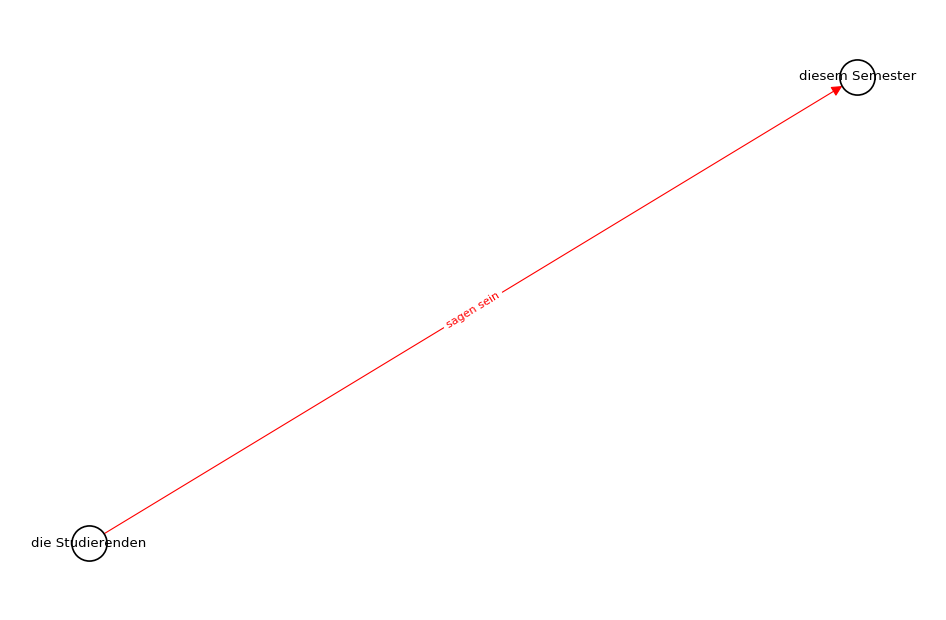

In [52]:
try:
    plt.figure(num=None, figsize=(15, 10), dpi=80)
    filter_graph(kg_df[kg_data_cols], 'die Studierenden')
except:
    print('Subjekt nicht gefunden')